# 데이터로드 및 모듈import

In [101]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time

from collections import Counter

plt.rc('font', family='NanumGothic') # For Windows
print(plt.rcParams['font.family'])
plt.rcParams['font.family'] = 'Malgun Gothic'

%matplotlib inline

import missingno
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler

import warnings
warnings.filterwarnings('ignore')

#Feature Importance Module
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

# metric
from sklearn.metrics import accuracy_score
from imblearn.over_sampling import SMOTE

# Model
import xgboost as xgb
import lightgbm as lgb
from sklearn.model_selection import GridSearchCV

['NanumGothic']


In [2]:
df = pd.read_csv("./data/nationalhealth_2010to2021.csv")
m_data = pd.read_excel("./data/meta_data20.xlsx")
df_20 = pd.read_csv("./data/national_only20_health_2010to2021.csv")

def trans(val): #변수 번역 input str
        return m_data["variable description"][m_data["variable"] == val].values[0]

def disc(val): #설문 내역
        return m_data["option description"][m_data["variable"] == val].values[0]
        
def change2None(data): #통계량을 측정할 때, 결측값 복원
    dataN = data.copy()
    for i in data.columns:
        dataN.replace({i:{-1:None}},inplace=True)
        dataN.replace({i:{-2:None}},inplace=True)
    return dataN


#타겟 + 피쳐 str list
col_li = df.columns.to_list() 
#타겟 str list
target_li = df.columns[-13:].to_list()
#피쳐 str list
fea_li = df.columns[:-13].to_list()

#범주형 자료 str list
temp = list(m_data["variable"][m_data['data type']== "category"].values)
cat_li = [i for i in temp if i in col_li] #범주형 자료 컬럼 : cat_li
#연속형 자료 str list
temp = list(m_data["variable"][m_data['data type']== "numeric"].values)
expcept = ['ID', 'ID_fam', 'LW_mt_a1', 'age', 'year']
num_li = [i for i in temp if i in col_li] #연속형 자료 컬럼 : num_li

# 연령별 Target 유병자 Kdeplot

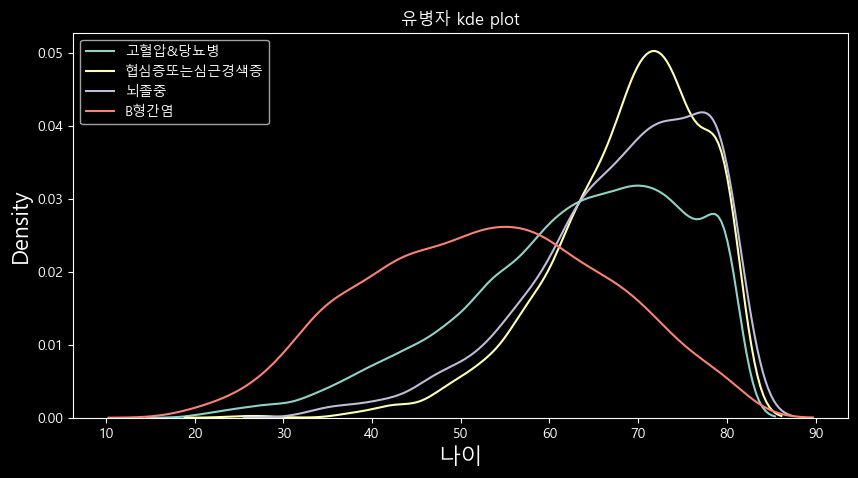

In [4]:
df_20to80 = pd.concat([df,df_20], ignore_index=True)
df_gd = df_20to80[['age', '고혈압', '당뇨병']]
df_gd['고당'] = np.where((df_gd['고혈압'] == 1)|(df_gd['당뇨병'] == 1), 1,0)
df_gd = df_gd[['age', '고당']]
df_gd = df_gd[df_gd['고당'] == 1]


df_h = df_20to80[['age', '협심증또는심근경색증']]
df_h = df_h[df_h['협심증또는심근경색증'] == 1]


df_b = df_20to80[['age', '뇌졸중']]
df_b = df_b[df_b['뇌졸중'] == 1]


df_B = df_20to80[['age', 'B형간염']]
df_B = df_B[df_B['B형간염'] == 1]

fig = plt.figure(figsize=(10,5))
fig.set_facecolor('black')
sns.kdeplot(df_gd['age'], shade=False,label ='고혈압&당뇨병')
sns.kdeplot(df_h['age'], shade=False,label ='협심증또는심근경색증')
sns.kdeplot(df_b['age'], shade=False,label ='뇌졸중')
sns.kdeplot(df_B['age'], shade=False,label ='B형간염')
plt.title('유병자 kde plot')
plt.style.use("dark_background")
plt.xlabel("나이", fontsize=16)
plt.ylabel("Density", fontsize=16)

plt.legend(loc = 'upper left', prop={'size': 10})
plt.show()

- 흰색 배경이 나오면 한번 더 실행해주세요

# 변수 타입별 column리스트 5가지 선언
- 이진형
- 범주형
- 연속형
- 질병변수
- Target

In [6]:
#타겟 + 피쳐 str list
col_li = df.columns.to_list() 
#타겟 str list
target_li = df.columns[-13:].to_list()
#피쳐 str list
fea_li = df.columns[:-13].to_list()

#범주형 자료 str list
temp = list(m_data["variable"][m_data['data type']== "category"].values)
cat_li = [i for i in temp if i in col_li] #범주형 자료 컬럼 : cat_li
#연속형 자료 str list
temp = list(m_data["variable"][m_data['data type']== "numeric"].values)
expcept = ['ID', 'ID_fam', 'LW_mt_a1', 'age', 'year']
num_li = [i for i in temp if i in col_li] #연속형 자료 컬럼 : num_li
bin_col = [i for i in col_li if len(df[i].unique()) < 4]

In [7]:
df_20to80 = pd.concat([df,df_20], ignore_index=True)
df_40 = df_20to80[(df_20to80['age'] >= 40)&(df_20to80['age'] < 50)]

cat_li = list(set(cat_li) - set(bin_col))
df_20to80 = df_20to80[cat_li +num_li + bin_col]

In [8]:
print('이진형 : ',bin_col)

이진형 :  ['town_t', 'sex', 'allownc', 'marri_1', 'EC1_1', 'dr_month', 'mh_stress', 'HE_HPdr', 'HE_DMdr', 'HE_mens', 'HE_prg', 'HE_HPfh1', 'HE_HPfh2', 'HE_HLfh1', 'HE_HLfh2', 'HE_IHDfh1', 'HE_IHDfh2', 'HE_STRfh1', 'HE_STRfh2', 'HE_DMfh1', 'HE_DMfh2', 'HE_rPLS', 'HE_hepaB', 'HE_Unitr', '비만', '고혈압', '당뇨병', '고콜레스테롤혈증', '고중성지방혈증', 'B형간염', '빈혈', '뇌졸중', '협심증또는심근경색증', '천식', '아토피피부염', '골관절염', '우울증']


In [9]:
print('범주형 : ',cat_li)
#범주형에서 이진형 빼주기

범주형 :  ['BP6_10', 'incm', 'cfam', 'tins', 'BS3_1', 'region', 'HE_DMfh3', 'occp', 'incm5', 'LW_mt', 'marri_2', 'EC_wht_5', 'EC_pedu_2', 'BD2_1', 'ho_incm5', 'BE3_31', 'HE_Ubld', 'BD1_11', 'educ', 'LW_br', 'HE_HPfh3', 'HE_STRfh3', 'D_1_1', 'HE_HLfh3', 'HE_Uro', 'EC_pedu_1', 'BP7', 'BE5_1', 'HE_Uglu', 'BD2_31', 'ho_incm', 'genertn', 'edu', 'HE_Ubil', 'HE_IHDfh3', 'fam_rela', 'HE_Upro', 'HE_Uket']


In [10]:
print('연속형 : ',num_li)

연속형 :  ['EC_wht_23', 'HE_fst', 'HE_sbp', 'HE_dbp', 'HE_ht', 'HE_wt', 'HE_wc', 'HE_BMI', 'HE_glu', 'HE_HbA1c', 'HE_chol', 'HE_HDL_st2', 'HE_TG', 'HE_ast', 'HE_alt', 'HE_HB', 'HE_HCT', 'HE_BUN', 'HE_crea', 'HE_WBC', 'HE_RBC', 'HE_Bplt', 'HE_Uph', 'HE_Usg', 'HE_Ucrea', 'N_INTK', 'N_EN', 'N_WATER', 'N_PROT', 'N_FAT', 'N_CHO', 'N_CA', 'N_PHOS', 'N_FE', 'N_NA', 'N_K', 'N_CAROT', 'N_RETIN', 'N_B1', 'N_B2', 'N_NIAC', 'N_VITC']


In [11]:
print('Target : ', target_li)

Target :  ['비만', '고혈압', '당뇨병', '고콜레스테롤혈증', '고중성지방혈증', 'B형간염', '빈혈', '뇌졸중', '협심증또는심근경색증', '천식', '아토피피부염', '골관절염', '우울증']


# Why insurance

In [12]:
for i in target_li :
    df_40[i] = np.where(df_40[i] == 1, 1, 0)

df_40['existence'] = np.where(df_40[target_li].sum(axis=1) > 0, 1, 0)
rate = round(sum(df_40['existence'])/len(df_40)*100, 1)
print('40세에서 13종류의 만성질환 합집합 비율은 : {}% 입니다.'.format(rate))

40세에서 13종류의 만성질환 합집합 비율은 : 63.7% 입니다.


# Feature reliance

## 4개 Target의 합집합으로 구성한 disease column(4개 중 하나라도 가지고 있으면 1, 없으면 0)

- 0                   kor  unique
- educ       0.089029              교육수준: 학력       8
- BD2_31     0.066604        (만12세이상) 폭음 빈도       7
- region     0.041658                17개 시도      17
- EC_pedu_2  0.037758  (성인) 유년기환경: 어머니 교육수준      10
- D_1_1      0.032334              주관적 건강인지       6
- HE_Uglu    0.028457                    요당       6
- EC_wht_5   0.019248                변형근로시간      10
- marri_2    0.017047                  결혼상태       7
- fam_rela   0.015490              가구주와의 관계      11
- HE_STRfh3  0.006165     뇌졸중 의사진단 여부(형제자매)       4

In [13]:
#타겟 변수 간 유사도 검정
dfN = change2None(df)

def score(col1, col2, df = df):
    intersection = (df[col1]==1) & (df[col2]==1)
    union_1 = (df[col1]==1) & (df[col2]==0)
    union_2 = (df[col1]==0) & (df[col2]==1)
    union_3 = (df[col1]==1) & (df[col2]==1)
    #print(sum(intersection) + (sum(union_1)+sum(union_2)+sum(union_3)))
    
    return sum(intersection) / (sum(union_1)+sum(union_2)+sum(union_3))


target = ["고혈압","당뇨병","B형간염","협심증또는심근경색증","뇌졸중"]

temp = [[score(i,target[j],dfN) for j in range(5)] for i in target]
temp
score = pd.DataFrame(temp, index = target, columns=target)

score

,고혈압,당뇨병,B형간염,협심증또는심근경색증,뇌졸중
고혈압,1.000000,0.247195,0.027806,0.072963,0.065834
당뇨병,0.247195,1.000000,0.025783,0.091290,0.071483
B형간염,0.027806,0.025783,1.000000,0.014412,0.012910
협심증또는심근경색증,0.072963,0.091290,0.014412,1.000000,0.062090
뇌졸중,0.065834,0.071483,0.012910,0.062090,1.000000


In [14]:
#Target on Project
cnt = 0
df_20to80["Target"] = [0 for i in range(len(df_20to80))]
for i in range(len(df_20to80)):
    if df_20to80['고혈압'][i] == 1.0 or df_20to80['B형간염'][i] or df_20to80['당뇨병'][i] == 1.0 or df_20to80['협심증또는심근경색증'][i] == 1.0 or df_20to80['뇌졸중'][i]:
        df_20to80["Target"][i] = 1.0
df_20to80["Target"].value_counts()

1    21080
0    18350
Name: Target, dtype: int64

In [15]:
def rf_fe_importance(data, target_name, data_type, num):
    '''
    랜덤포레스트로 변수중요도 구하기
        target_name : 변수이름
        num : 상위n개 변수 뽑기
    '''
    if data_type == "binary":
        features = data.loc[:, bin_col].columns.drop(target_li)
    elif data_type == "cataegory":
        features = data.loc[:, cat_li].columns
    elif data_type == "numeric":
        features = data.loc[:, num_li].columns
    elif data_type == "all": 
        features = data.loc[:, num_li+cat_li+bin_col].columns
    
    X = data[features]
    y = data[target_name]

    X_train, X_test, y_train, y_test = train_test_split(X,y,stratify = y,test_size=0.1, random_state=42)

    model = RandomForestClassifier(n_estimators=5, random_state=0, max_depth = 15)
    model.fit(X_train, y_train)

    predict = model.predict(X_test)
    print("tain set accuracy: ", metrics.accuracy_score(y_train, model.predict(X_train)))
    print("test set accuracy: ", metrics.accuracy_score(y_test, model.predict(X_test)))
    df = pd.DataFrame(model.feature_importances_, index =features)[:num].sort_values(0, ascending=False)
    return df

In [16]:
FI_b = rf_fe_importance(df_20to80,"Target","binary",10)
arr = [trans(i) for i in list(FI_b.index)] ; FI_b["kor"] = arr
arr2 = [len(df_20to80[i].unique()) for i in list(FI_b.index)] ; FI_b["unique"] = arr2
print("\n")
FI_n = rf_fe_importance(df_20to80,"Target","numeric",10)
arr = [trans(i) for i in list(FI_n.index)] ; FI_n["kor"] = arr
arr2 = [len(df_20to80[i].unique()) for i in list(FI_n.index)] ; FI_n["unique"] = arr2
print("\n")
FI_c = rf_fe_importance(df_20to80,"Target","cataegory",10)
arr = [trans(i) for i in list(FI_c.index)] ; FI_c["kor"] = arr
arr2 = [len(df_20to80[i].unique()) for i in list(FI_c.index)] ; FI_c["unique"] = arr2

tain set accuracy:  0.7045396905909206
test set accuracy:  0.6905909206188181


tain set accuracy:  0.9265364781469271
test set accuracy:  0.7839208724321582


tain set accuracy:  0.8580888776171556
test set accuracy:  0.7438498605123003


In [17]:
print("binary")
print(FI_b)
print("\n")
print("numeric")
print(FI_n)
print("\n")
print("cataegory")
print("\n")
print(FI_c)
print("\n")

binary
                  0               kor  unique
HE_HPdr    0.172091  검진당일 고혈압 약 복용 여부       3
marri_1    0.141952              결혼여부       3
HE_DMdr    0.108331  검진당일 당뇨병 약 복용 여부       3
EC1_1      0.046241           경제활동 상태       2
HE_mens    0.032885              생리여부       3
dr_month   0.032359             월간음주율       2
town_t     0.027064           동/읍면 구분       2
sex        0.022406                성별       2
mh_stress  0.020309          스트레스 인지율       2
allownc    0.017967         기초생활수급 여부       3


numeric
                  0                 kor  unique
HE_sbp     0.161190  최종 수축기 혈압(2,3차 평균)     237
HE_HbA1c   0.142146               당화혈색소     110
HE_dbp     0.063906  최종 이완기 혈압(2,3차 평균)     167
HE_glu     0.036169                공복혈당     272
HE_wc      0.024127                허리둘레     672
HE_ht      0.019919                  신장     622
HE_BMI     0.018663               체질량지수   32639
EC_wht_23  0.014835          주당 평균 근로시간     124
HE_wt      0.012269                  체중     8

## 이진형, 범주형 column에 대한 상관 분석 시행


- BD1_11     0.056553       (만12세이상) 1년간 음주빈도       7
- BD2_1      0.036119   (만12세이상) 한 번에 마시는 음주량       7
- BS3_1      0.022957  (성인) 현재 일반담배(궐련) 흡연 여부       5
- BP7        0.022170             1년간 정신문제 상담       4
- incm5      0.019225             소득 5분위수(개인)       5
- HE_Ubld    0.016473                     요잠혈       6
- LW_br      0.014483              모유수유 경험 여부       4
- HE_DMfh3   0.011815       당뇨병 의사진단 여부(형제자매)       4
- HE_HLfh3   0.006513      고지혈증 의사진단 여부(형제자매)       4
- HE_IHDfh3  0.005887   허혈성심장질환 의사진단 여부(형제자매)       4

In [18]:
##상관계수 데이터프레임 만들기 
def do_corr_analysis(data,columns:list) :


    corr = data[columns].corr()
    corr = pd.melt(corr.reset_index(), id_vars='index')
    
    if columns == bin_col :
        corr = corr[(corr['value'] > 0.4)|(corr['value'] < -0.4)]
    else :
        corr = corr[((corr['value'] > 0.4)&(corr['value'] < 0.99))|((corr['value'] < -0.4)&(corr['value'] > -0.99))]
    
    ##ind2int
    ind_dic = {}
    for ii, ind in enumerate(set(corr['index'])):
        ind_dic[ind] = ii
    ind_dic

    corr['index2values'] = corr['index'].map(ind_dic)
    corr['variable2values'] = corr['variable'].map(ind_dic)

    ##시각화
    fig = plt.figure(figsize=(50,50))

    x = corr['index2values'].values
    y = corr['variable2values'].values
    size = corr['value'].values*1000
    plt.scatter(x, y, # y
               alpha=0.7, 
               s=size*8, # marker size
               c=size*8, # marker color
               cmap='viridis')
    plt.style.use("dark_background")
    plt.title('범주형변수-bin_li 상관관계', fontsize=10)
    plt.xticks(np.arange(len(set(x))),ind_dic.keys())
    plt.yticks(np.arange(len(set(x))),ind_dic.keys())
    plt.colorbar()
    plt.show()


    ##번역된 변수 칼럼 만들기 
    trans_index_li = []
    for ii in corr['index'].values:
        try :
            translate_in = trans(ii)
            trans_index_li.append(translate_in)
        except :
            trans_index_li.append(ii)

    trans_variable_li = []
    for jj in corr['variable'].values:
        try :
            translate_va = trans(jj)
            trans_variable_li.append(translate_va)
        except :
            trans_variable_li.append(jj)

    corr['index_trans'] = trans_index_li
    corr['variable_trans'] = trans_variable_li

    corr = corr[['index','variable', 'index_trans', 'variable_trans', 'index2values', 'variable2values', 'value']]
    corr = corr.sort_values(by=['value'], ascending=False)
    corr.reset_index(drop=True, inplace=True)

    ## (index, variable) (vairable, index)중복된 값들 제거
    corr[['index', 'variable']].values


    dic_indva = {}
    indva = []
    for ii, (ind, va) in enumerate(corr[['index', 'variable']].values):
        if ii == 0:
            indva.append((ind,va))
            dic_indva[ii] = (ind, va)
        else :
            if (va,ind) in indva :
                pass 
            else :
                indva.append((ind,va))
                dic_indva[ii] = (ind,va)

    corr = corr.iloc[list(dic_indva.keys())]
    corr.reset_index(drop=True, inplace=True)
    return corr

### 이진형에 대한 상관분석 시행

In [19]:
df1 = change2None(df_20to80[bin_col])
df1 = df1.fillna(0)
df1

,town_t,sex,allownc,marri_1,EC1_1,dr_month,mh_stress,HE_HPdr,HE_DMdr,HE_mens,...,고콜레스테롤혈증,고중성지방혈증,B형간염,빈혈,뇌졸중,협심증또는심근경색증,천식,아토피피부염,골관절염,우울증
0,1.0,1.0,20.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1.0,2.0,20.0,1.0,2.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1.0,2.0,20.0,1.0,2.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
3,1.0,1.0,20.0,2.0,1.0,1.0,1.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,1.0,2.0,20.0,1.0,2.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39425,1.0,2.0,20.0,2.0,2.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
39426,1.0,1.0,10.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
39427,1.0,2.0,10.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
39428,2.0,2.0,20.0,2.0,2.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


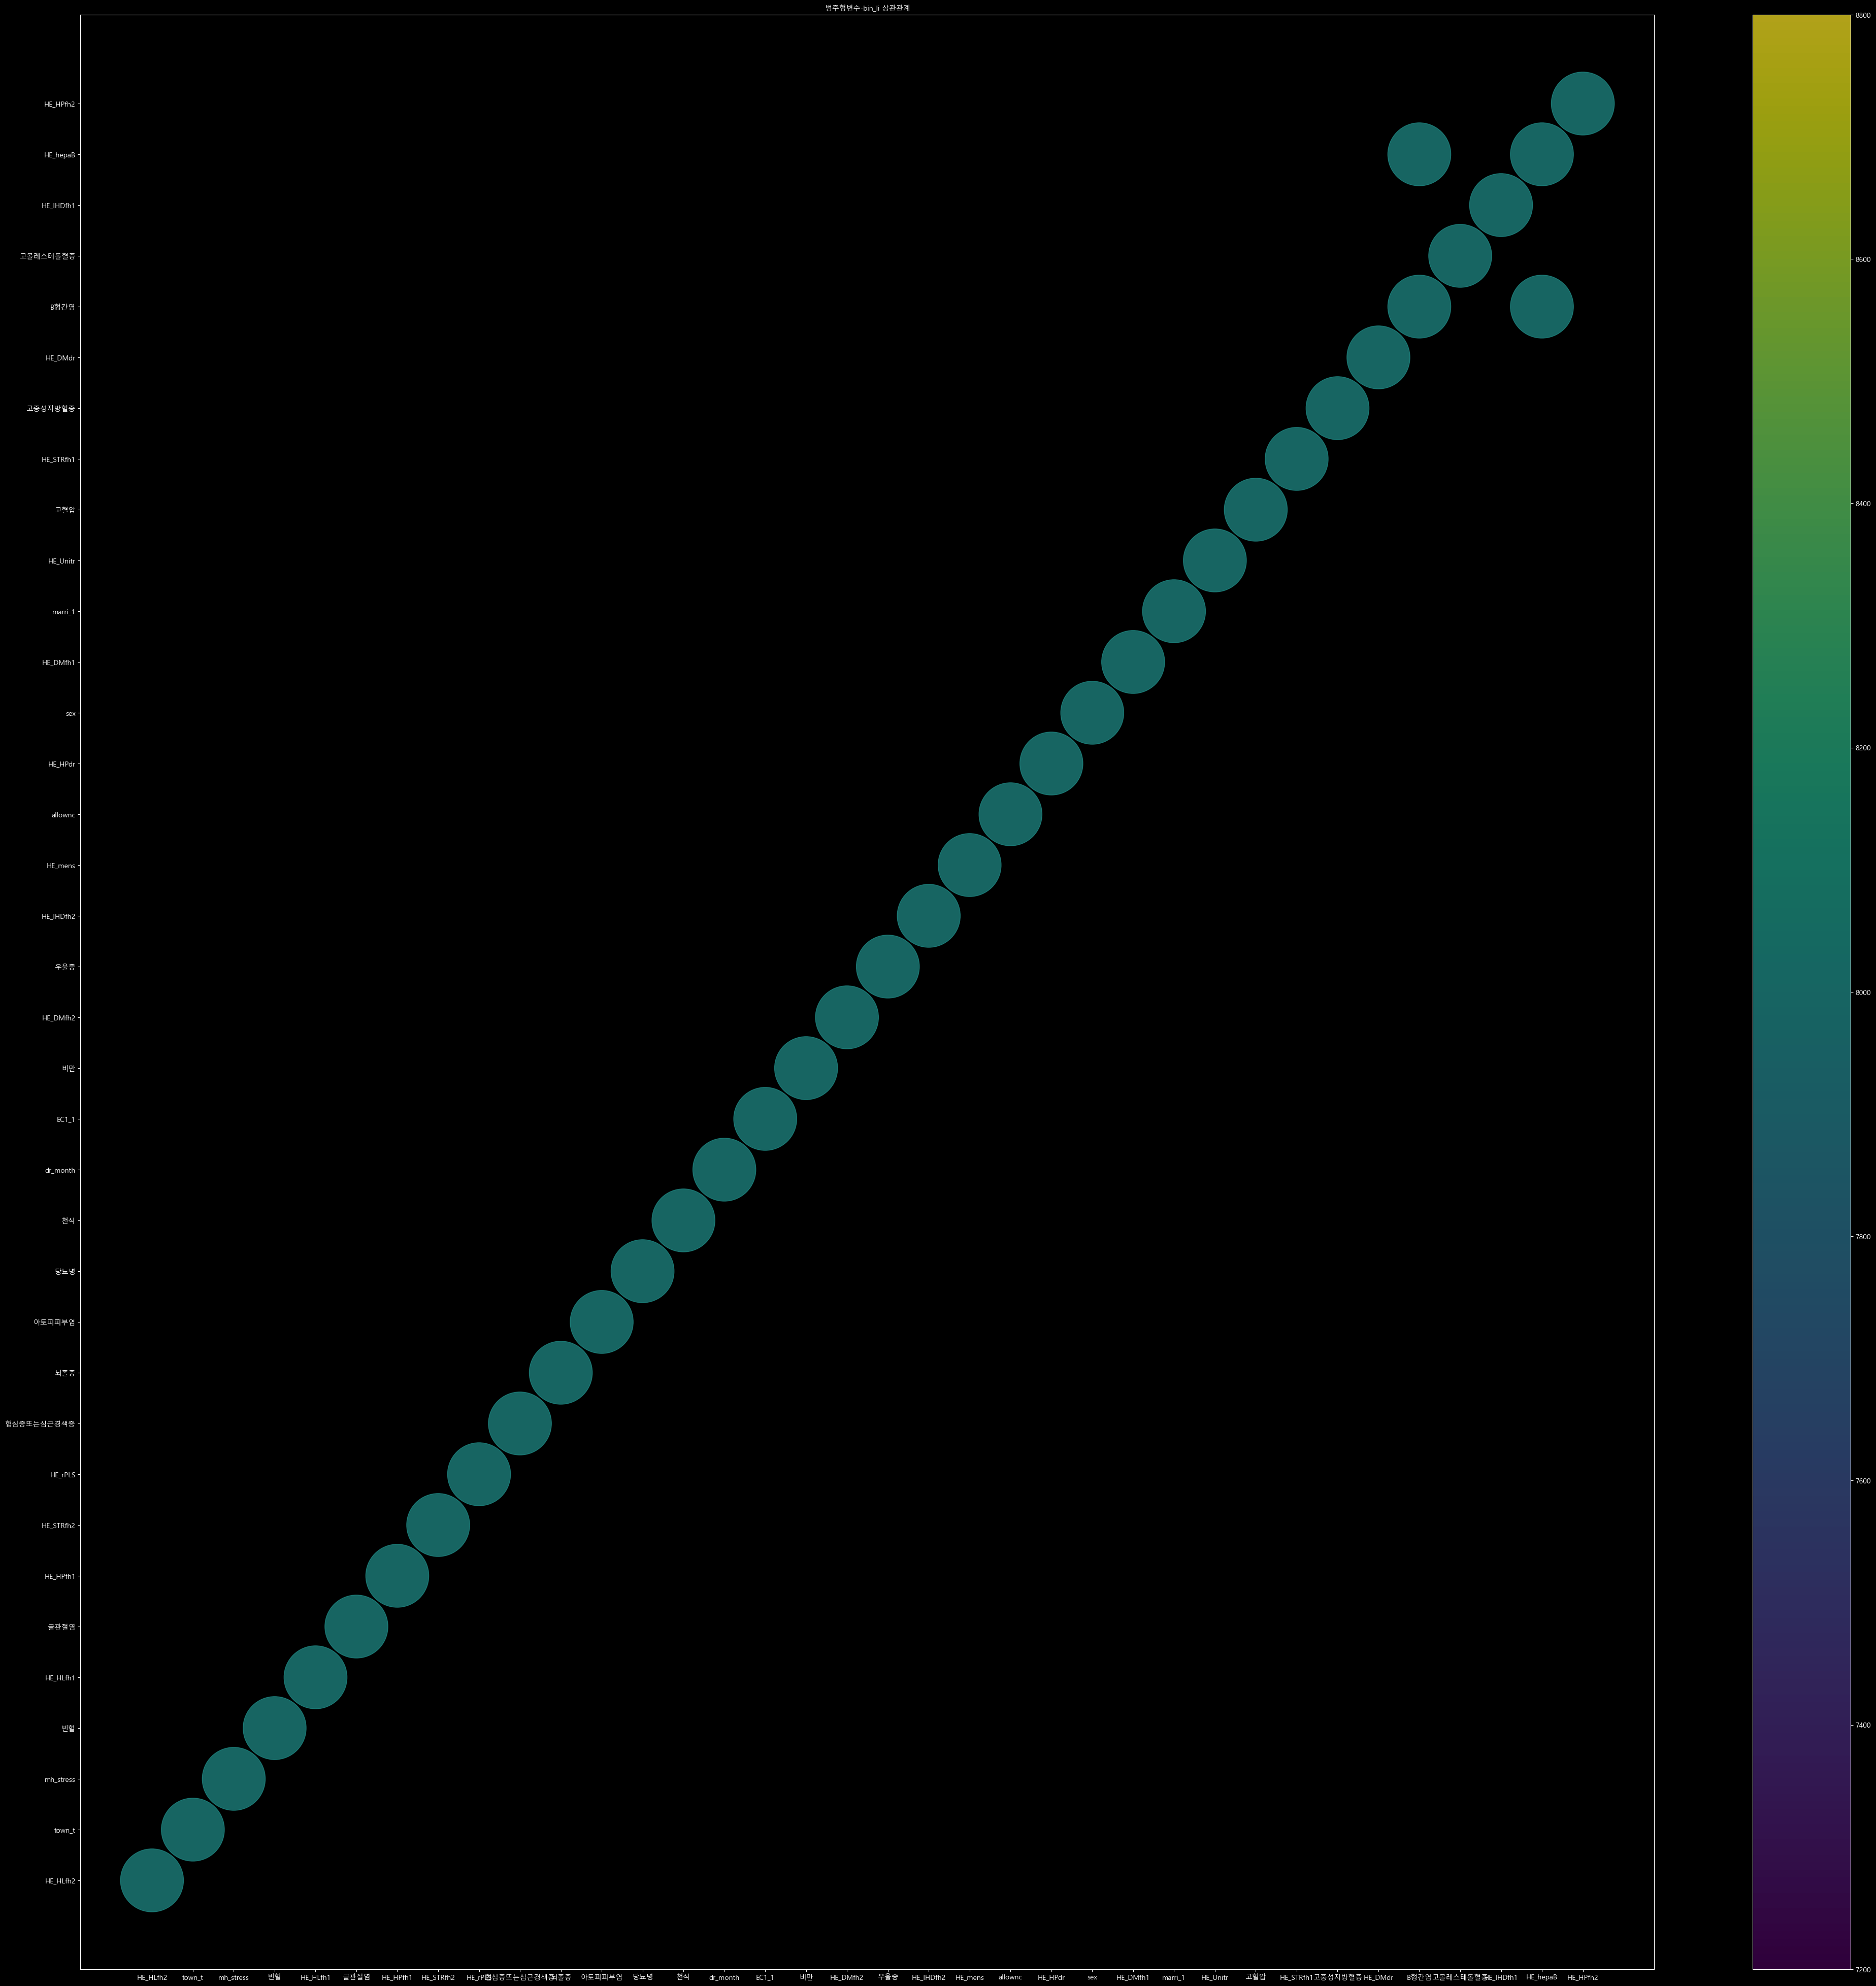

In [20]:
bin_corr = do_corr_analysis(df1, bin_col)

In [21]:
bin_ind = []
for ii in range(len(bin_corr)):
    if bin_corr.iloc[ii]['index'] != bin_corr.iloc[ii]['variable'] :
        bin_ind.append(ii)
bin_corr.iloc[bin_ind]

,index,variable,index_trans,variable_trans,index2values,variable2values,value
3,B형간염,HE_hepaB,B형간염,B형간염표면항원 양성여부(10세이상),31,34,1.0


독립관계가 아닌 종속관계에 있으니까 'HE_hepaB' 변수를 빼야한다. 

In [22]:
bin_col = list(set(bin_col) - set(['HE_hepaB']))

### 범주형에 대한 상관분석 시행

In [23]:
cat_minus_bin_li = list(set(cat_li) - set(bin_col))

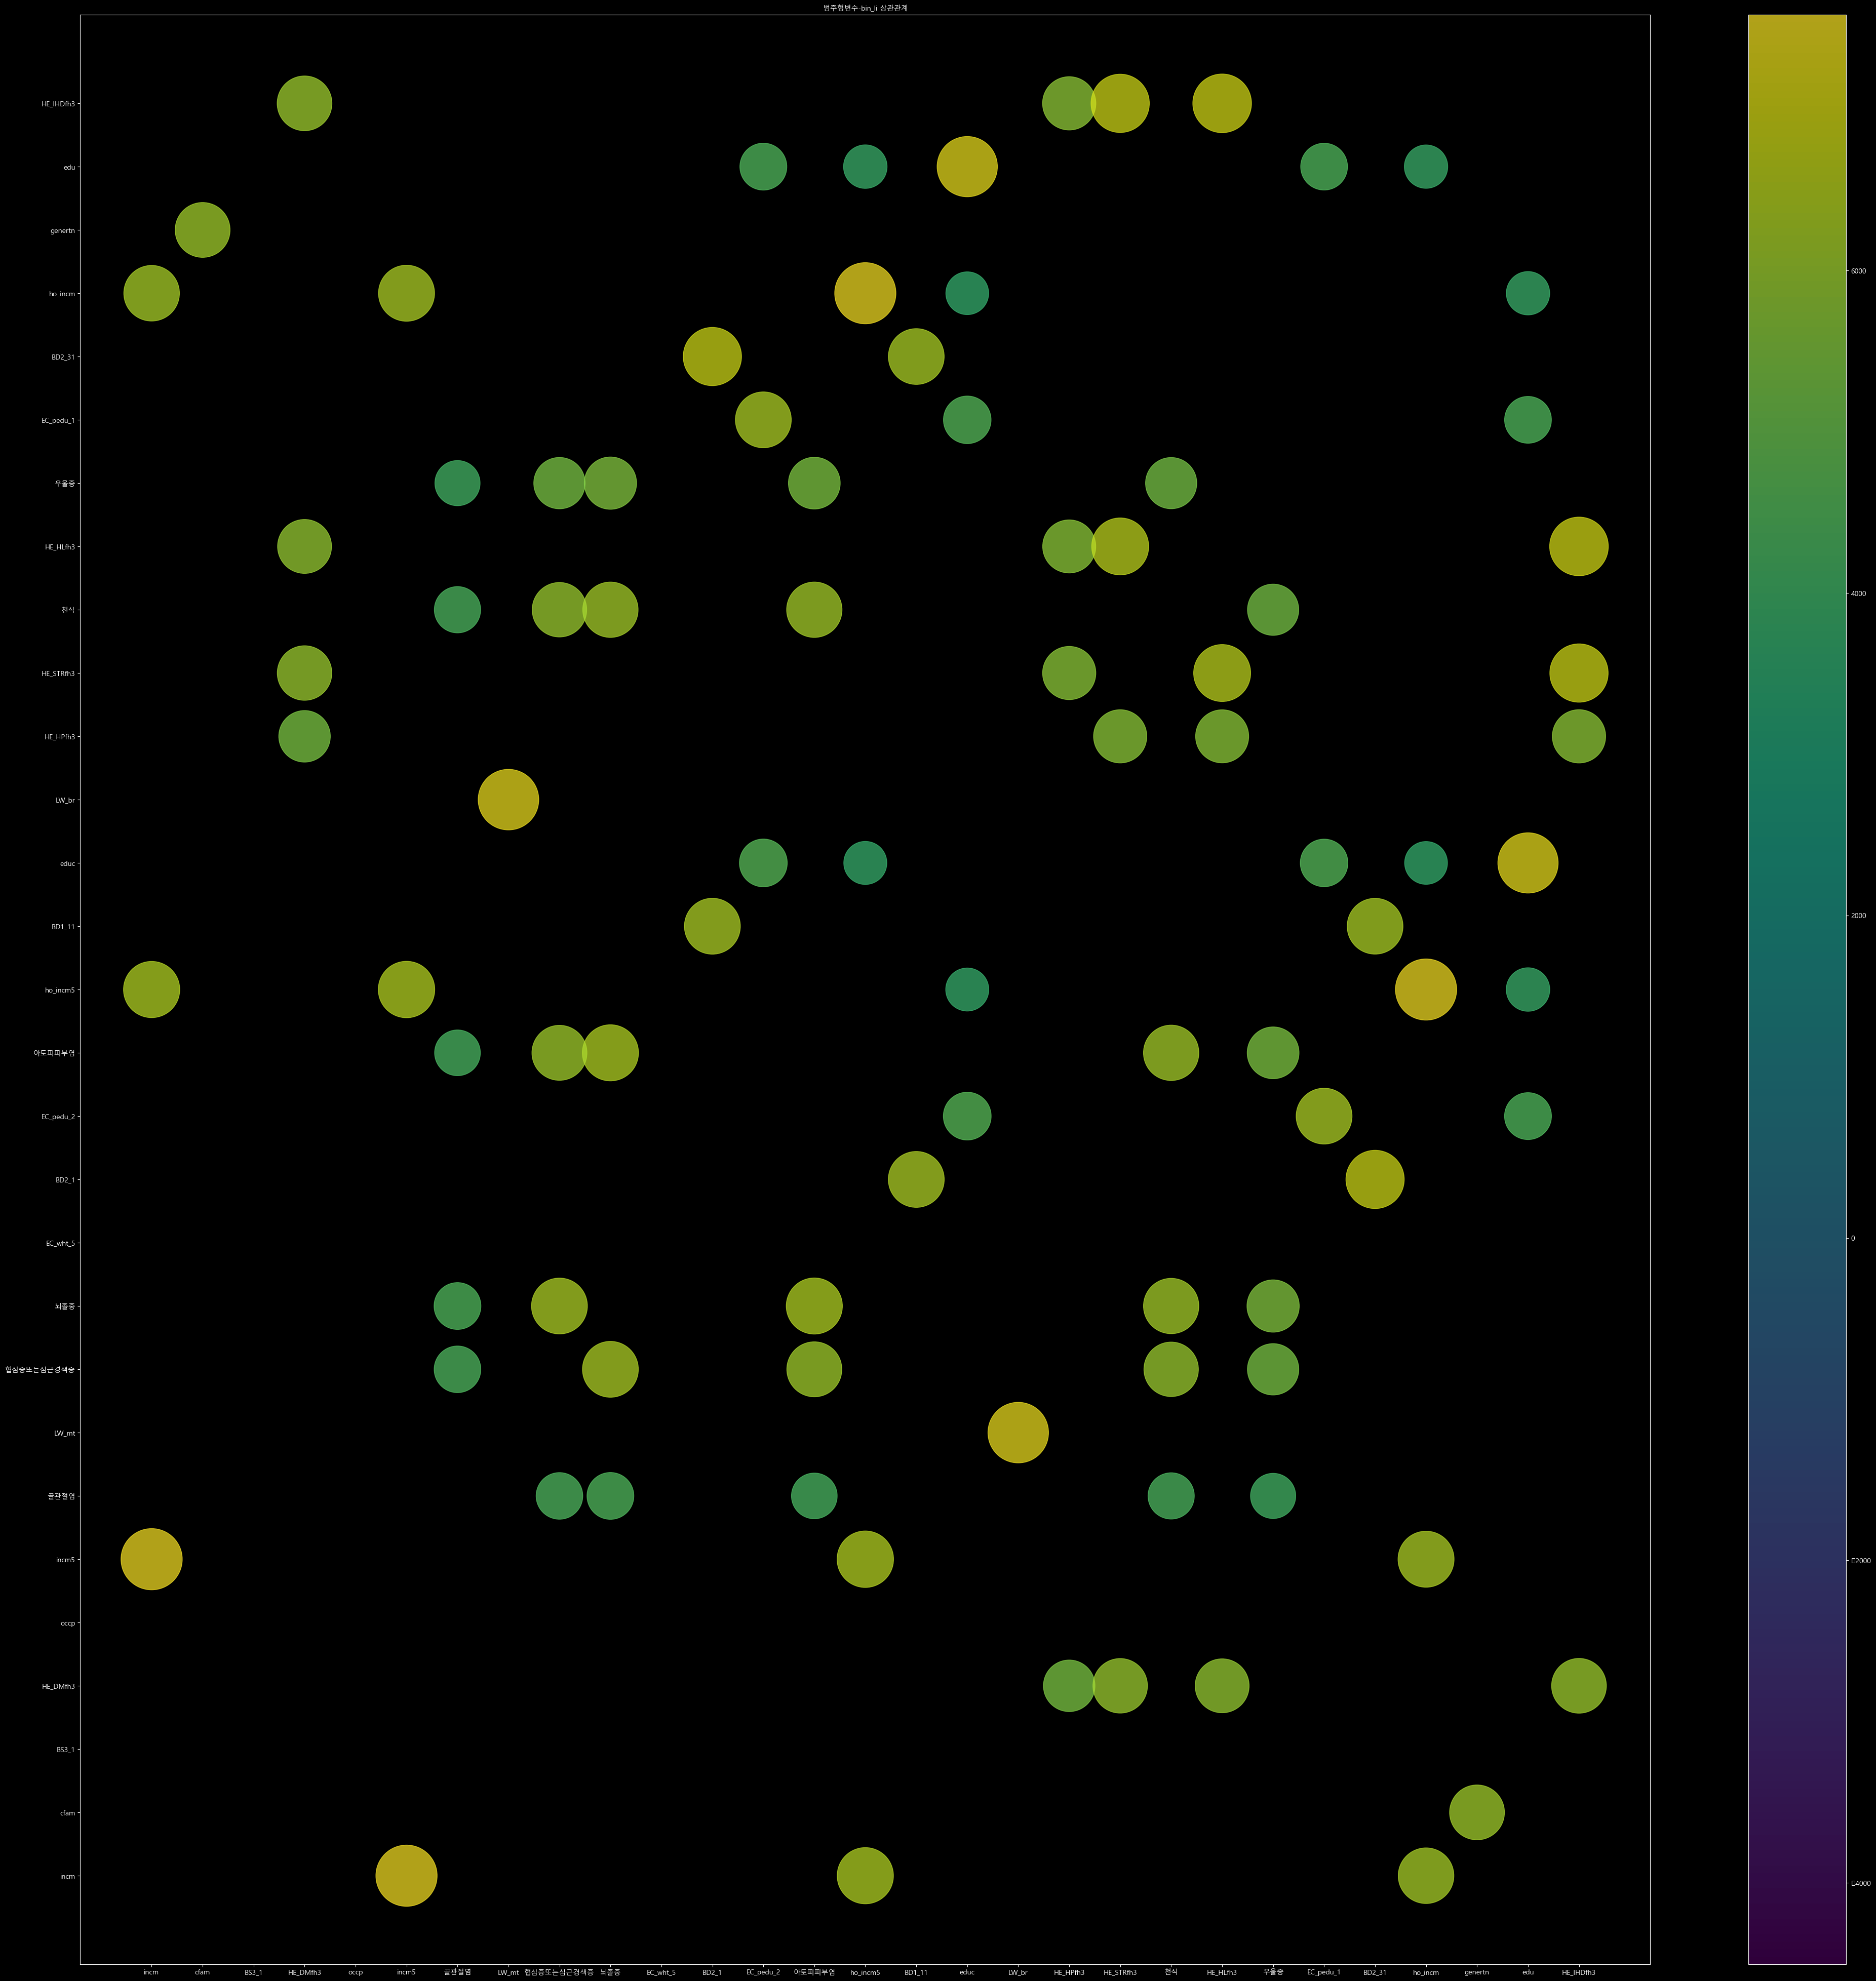

In [24]:
corr = do_corr_analysis(df_20to80 ,cat_minus_bin_li + target_li)

In [25]:
##FI가 높은 칼럼들 상관분석 시행
wosun_li = ['BD1_11', 'BD2_1', 'BS3_1', 'BP7', 'incm5', 'HE_Ubld', 'LW_br', 'HE_DMfh3', 'HE_HLfh3', 'HE_IHDfh3']

In [26]:
#index에 있는 칼럼들 기준으로 시행
include_ind = []
for ii in range(len(corr)):
    if corr.loc[ii, 'index'] in wosun_li : 
        include_ind.append(ii)
        
#variable에 있는 칼럼들 기준으로 시행
include_variable = []
for ii in range(len(corr)):
    if corr.loc[ii, 'variable'] in wosun_li:
        include_variable.append(ii)

print('include_ind : ', include_ind)
print('include_variable : ', include_variable)

include_ind :  [0, 4, 6, 7, 12, 15, 21, 22, 24, 49, 50]
include_variable :  [2, 4, 5, 8, 11, 12, 21, 24, 25, 27, 30, 46, 49]


## 이진형, 범주형 column에 대한 상관분석1

In [27]:
corr.iloc[include_ind]

,index,variable,index_trans,variable_trans,index2values,variable2values,value
0,incm5,incm,소득 5분위수(개인),소득 4분위수(개인),5,0,0.948330
4,HE_IHDfh3,HE_HLfh3,허혈성심장질환 의사진단 여부(형제자매),고지혈증 의사진단 여부(형제자매),28,21,0.870832
6,BD2_1,BD2_31,(만12세이상) 한 번에 마시는 음주량,(만12세이상) 폭음 빈도,11,24,0.859178
7,HE_HLfh3,HE_STRfh3,고지혈증 의사진단 여부(형제자매),뇌졸중 의사진단 여부(형제자매),21,19,0.821643
12,BD1_11,BD2_1,(만12세이상) 1년간 음주빈도,(만12세이상) 한 번에 마시는 음주량,15,11,0.790703
15,BD1_11,BD2_31,(만12세이상) 1년간 음주빈도,(만12세이상) 폭음 빈도,15,24,0.787558
21,HE_DMfh3,HE_IHDfh3,당뇨병 의사진단 여부(형제자매),허혈성심장질환 의사진단 여부(형제자매),3,28,0.758486
22,HE_DMfh3,HE_STRfh3,당뇨병 의사진단 여부(형제자매),뇌졸중 의사진단 여부(형제자매),3,19,0.752624
24,HE_DMfh3,HE_HLfh3,당뇨병 의사진단 여부(형제자매),고지혈증 의사진단 여부(형제자매),3,21,0.736230
49,BS3_1,LW_br,(성인) 현재 일반담배(궐련) 흡연 여부,모유수유 경험 여부,2,17,-0.537461


- 형제자매를 대상으로 성인병 의사진단 여부를 묻는 문항은 만성질환 의사진단 여부로 포함
- 음주량 관련 칼럼들 : 계수값이 차이가 나지 않고, 결측값이 가장 적은 '1년간 음주빈도'변수만 선택

## 이진형, 범주형 column에 대한 상관분석2

In [28]:
corr.iloc[include_variable]

,index,variable,index_trans,variable_trans,index2values,variable2values,value
2,LW_mt,LW_br,(만15세이상) 출산경험,모유수유 경험 여부,7,17,0.928125
4,HE_IHDfh3,HE_HLfh3,허혈성심장질환 의사진단 여부(형제자매),고지혈증 의사진단 여부(형제자매),28,21,0.870832
5,HE_STRfh3,HE_IHDfh3,뇌졸중 의사진단 여부(형제자매),허혈성심장질환 의사진단 여부(형제자매),19,28,0.860333
8,ho_incm5,incm5,소득 5분위수(가구),소득 5분위수(개인),14,5,0.806367
11,ho_incm,incm5,소득 4분위수(가구),소득 5분위수(개인),25,5,0.794133
12,BD1_11,BD2_1,(만12세이상) 1년간 음주빈도,(만12세이상) 한 번에 마시는 음주량,15,11,0.790703
21,HE_DMfh3,HE_IHDfh3,당뇨병 의사진단 여부(형제자매),허혈성심장질환 의사진단 여부(형제자매),3,28,0.758486
24,HE_DMfh3,HE_HLfh3,당뇨병 의사진단 여부(형제자매),고지혈증 의사진단 여부(형제자매),3,21,0.736230
25,HE_HPfh3,HE_IHDfh3,고혈압 의사진단 여부(형제자매),허혈성심장질환 의사진단 여부(형제자매),18,28,0.718298
27,HE_HPfh3,HE_HLfh3,고혈압 의사진단 여부(형제자매),고지혈증 의사진단 여부(형제자매),18,21,0.712400


- 소득분위 관련 변수 : 'incm5'칼럼만 선택
- '출산경험'과 ''모유수유 경험여부' 칼럼 중 유의미한 '모유수유 경험여부'칼럼만 선택

# Control Features

1. 형제자매 만성질환 의사진단 여부 칼럼 추가
2. 형제자매 만성질환 의사진단 여부 외 관련 칼럼 제거
3. 'LW_mt'(출산경험) 삭제
4. 소득 관련 칼럼 : 'incm5'외 제외
5. 음주 관련 칼럼 : 'BD1_11'외 제외

## 1. 형제자매 만성질환 의사진단 여부 칼럼 추가

In [29]:
brother_sister_li = []

for col in df_20to80.columns:
    if 'fh3' in col :
        brother_sister_li.append(col)
        
for i in brother_sister_li :
    df_20to80[i] = np.where(df_20to80[i] == 1, 1, 0)

df_20to80['bro_sis_existence'] = np.where(df_20to80[brother_sister_li].sum(axis=1) > 0, 1, 0)

## 2. 형제자매 만성질환 의사진단 여부 외 관련 칼럼 제거

In [30]:
df_20to80.drop(brother_sister_li, axis=1, inplace=True)
df_20to80

,BP6_10,incm,cfam,tins,BS3_1,region,occp,incm5,LW_mt,marri_2,...,B형간염,빈혈,뇌졸중,협심증또는심근경색증,천식,아토피피부염,골관절염,우울증,Target,bro_sis_existence
0,1.0,3.0,2.0,10.0,3.0,1.0,3.0,4.0,-1.0,1.0,...,0.0,0.0,-1.0,-1.0,0.0,-1.0,-1.0,-1.0,1,0
1,2.0,2.0,2.0,20.0,-1.0,1.0,7.0,2.0,1.0,1.0,...,0.0,0.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,1,1
2,2.0,3.0,2.0,10.0,-1.0,1.0,7.0,4.0,1.0,1.0,...,0.0,0.0,-1.0,-1.0,1.0,-1.0,1.0,-1.0,1,0
3,2.0,2.0,2.0,10.0,1.0,1.0,5.0,2.0,-1.0,8.0,...,0.0,0.0,-1.0,-1.0,-1.0,-1.0,-1.0,1.0,1,0
4,2.0,4.0,1.0,10.0,-1.0,1.0,7.0,5.0,1.0,3.0,...,0.0,0.0,-1.0,-1.0,-1.0,-1.0,1.0,-1.0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39425,2.0,4.0,4.0,20.0,-1.0,8.0,7.0,4.0,-1.0,-1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0
39426,2.0,3.0,2.0,20.0,-1.0,8.0,1.0,4.0,-1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0
39427,2.0,3.0,2.0,20.0,-1.0,8.0,1.0,4.0,-1.0,1.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0,0
39428,2.0,4.0,3.0,20.0,-1.0,8.0,7.0,5.0,-1.0,-1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0


## 3. 'LW_mt'(출산경험) 삭제

In [31]:
df_20to80.drop(['LW_mt'], axis=1, inplace=True)

## 4. 소득 관련 칼럼 : 'incm5'외 제외

In [32]:
incm_li = []

for col in df_20to80.columns:
    if 'incm' in col :
        incm_li.append(col)
incm_li

['incm', 'incm5', 'ho_incm5', 'ho_incm']

In [33]:
df_20to80.drop(['incm', 'ho_incm', 'ho_incm5'], axis=1, inplace=True)

## 5. 음주 관련 칼럼 : 'BD1_11'외 제외

In [34]:
BD_li = []

for col in df_20to80.columns:
    if 'BD' in col :
        BD_li.append(col)
BD_li

['BD2_1', 'BD1_11', 'BD2_31']

In [35]:
df_20to80.drop(['BD2_1', 'BD2_31'], axis=1, inplace=True)

In [38]:
df_20to80.to_csv('./data/national_20to80.csv')

# Data preprocessing 

In [39]:
all_data = pd.read_csv('./data/national_20to80.csv', index_col=0)
display(all_data)

,BP6_10,cfam,tins,BS3_1,region,occp,incm5,marri_2,EC_wht_5,EC_pedu_2,...,B형간염,빈혈,뇌졸중,협심증또는심근경색증,천식,아토피피부염,골관절염,우울증,Target,bro_sis_existence
0,1.0,2.0,10.0,3.0,1.0,3.0,4.0,1.0,1.0,3.0,...,0.0,0.0,-1.0,-1.0,0.0,-1.0,-1.0,-1.0,1,0
1,2.0,2.0,20.0,-1.0,1.0,7.0,2.0,1.0,-1.0,-2.0,...,0.0,0.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,1,1
2,2.0,2.0,10.0,-1.0,1.0,7.0,4.0,1.0,-1.0,3.0,...,0.0,0.0,-1.0,-1.0,1.0,-1.0,1.0,-1.0,1,0
3,2.0,2.0,10.0,1.0,1.0,5.0,2.0,8.0,1.0,5.0,...,0.0,0.0,-1.0,-1.0,-1.0,-1.0,-1.0,1.0,1,0
4,2.0,1.0,10.0,-1.0,1.0,7.0,5.0,3.0,-1.0,1.0,...,0.0,0.0,-1.0,-1.0,-1.0,-1.0,1.0,-1.0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39425,2.0,4.0,20.0,-1.0,8.0,7.0,4.0,-1.0,-1.0,5.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0
39426,2.0,2.0,20.0,-1.0,8.0,1.0,4.0,1.0,1.0,8.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0
39427,2.0,2.0,20.0,-1.0,8.0,1.0,4.0,1.0,1.0,7.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0,0
39428,2.0,3.0,20.0,-1.0,8.0,7.0,5.0,-1.0,-1.0,5.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0


## target feature engineering

In [41]:
all_data = all_data.drop(['비만', '고콜레스테롤혈증', '고중성지방혈증', '빈혈', '천식',
                           '아토피피부염', '골관절염', '우울증'], axis=1)

display(all_data)

,BP6_10,cfam,tins,BS3_1,region,occp,incm5,marri_2,EC_wht_5,EC_pedu_2,...,HE_rPLS,HE_hepaB,HE_Unitr,고혈압,당뇨병,B형간염,뇌졸중,협심증또는심근경색증,Target,bro_sis_existence
0,1.0,2.0,10.0,3.0,1.0,3.0,4.0,1.0,1.0,3.0,...,1.0,0.0,0.0,0.0,1.0,0.0,-1.0,-1.0,1,0
1,2.0,2.0,20.0,-1.0,1.0,7.0,2.0,1.0,-1.0,-2.0,...,1.0,0.0,0.0,1.0,1.0,0.0,-1.0,-1.0,1,1
2,2.0,2.0,10.0,-1.0,1.0,7.0,4.0,1.0,-1.0,3.0,...,1.0,0.0,0.0,1.0,1.0,0.0,-1.0,-1.0,1,0
3,2.0,2.0,10.0,1.0,1.0,5.0,2.0,8.0,1.0,5.0,...,1.0,0.0,0.0,0.0,1.0,0.0,-1.0,-1.0,1,0
4,2.0,1.0,10.0,-1.0,1.0,7.0,5.0,3.0,-1.0,1.0,...,1.0,0.0,0.0,1.0,1.0,0.0,-1.0,-1.0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39425,2.0,4.0,20.0,-1.0,8.0,7.0,4.0,-1.0,-1.0,5.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0
39426,2.0,2.0,20.0,-1.0,8.0,1.0,4.0,1.0,1.0,8.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0
39427,2.0,2.0,20.0,-1.0,8.0,1.0,4.0,1.0,1.0,7.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0
39428,2.0,3.0,20.0,-1.0,8.0,7.0,5.0,-1.0,-1.0,5.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0


In [42]:
def trans(x):
    if x == -1:
        return 0
    else:
        return int(x)

target = ['고혈압', '당뇨병', 'B형간염', '뇌졸중', '협심증또는심근경색증']
all_data[target] = all_data[target].applymap(trans)
all_data

,BP6_10,cfam,tins,BS3_1,region,occp,incm5,marri_2,EC_wht_5,EC_pedu_2,...,HE_rPLS,HE_hepaB,HE_Unitr,고혈압,당뇨병,B형간염,뇌졸중,협심증또는심근경색증,Target,bro_sis_existence
0,1.0,2.0,10.0,3.0,1.0,3.0,4.0,1.0,1.0,3.0,...,1.0,0.0,0.0,0,1,0,0,0,1,0
1,2.0,2.0,20.0,-1.0,1.0,7.0,2.0,1.0,-1.0,-2.0,...,1.0,0.0,0.0,1,1,0,0,0,1,1
2,2.0,2.0,10.0,-1.0,1.0,7.0,4.0,1.0,-1.0,3.0,...,1.0,0.0,0.0,1,1,0,0,0,1,0
3,2.0,2.0,10.0,1.0,1.0,5.0,2.0,8.0,1.0,5.0,...,1.0,0.0,0.0,0,1,0,0,0,1,0
4,2.0,1.0,10.0,-1.0,1.0,7.0,5.0,3.0,-1.0,1.0,...,1.0,0.0,0.0,1,1,0,0,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39425,2.0,4.0,20.0,-1.0,8.0,7.0,4.0,-1.0,-1.0,5.0,...,1.0,0.0,0.0,0,0,0,0,0,0,0
39426,2.0,2.0,20.0,-1.0,8.0,1.0,4.0,1.0,1.0,8.0,...,1.0,0.0,0.0,0,0,0,0,0,0,0
39427,2.0,2.0,20.0,-1.0,8.0,1.0,4.0,1.0,1.0,7.0,...,1.0,0.0,0.0,0,0,0,0,0,0,0
39428,2.0,3.0,20.0,-1.0,8.0,7.0,5.0,-1.0,-1.0,5.0,...,1.0,0.0,0.0,0,0,0,0,0,0,0


In [43]:
all_data['고혈압&당뇨'] = (all_data['고혈압'] + all_data['당뇨병']).apply(lambda x: 0 if x == 0 else 1)
display(all_data)

,BP6_10,cfam,tins,BS3_1,region,occp,incm5,marri_2,EC_wht_5,EC_pedu_2,...,HE_hepaB,HE_Unitr,고혈압,당뇨병,B형간염,뇌졸중,협심증또는심근경색증,Target,bro_sis_existence,고혈압&당뇨
0,1.0,2.0,10.0,3.0,1.0,3.0,4.0,1.0,1.0,3.0,...,0.0,0.0,0,1,0,0,0,1,0,1
1,2.0,2.0,20.0,-1.0,1.0,7.0,2.0,1.0,-1.0,-2.0,...,0.0,0.0,1,1,0,0,0,1,1,1
2,2.0,2.0,10.0,-1.0,1.0,7.0,4.0,1.0,-1.0,3.0,...,0.0,0.0,1,1,0,0,0,1,0,1
3,2.0,2.0,10.0,1.0,1.0,5.0,2.0,8.0,1.0,5.0,...,0.0,0.0,0,1,0,0,0,1,0,1
4,2.0,1.0,10.0,-1.0,1.0,7.0,5.0,3.0,-1.0,1.0,...,0.0,0.0,1,1,0,0,0,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39425,2.0,4.0,20.0,-1.0,8.0,7.0,4.0,-1.0,-1.0,5.0,...,0.0,0.0,0,0,0,0,0,0,0,0
39426,2.0,2.0,20.0,-1.0,8.0,1.0,4.0,1.0,1.0,8.0,...,0.0,0.0,0,0,0,0,0,0,0,0
39427,2.0,2.0,20.0,-1.0,8.0,1.0,4.0,1.0,1.0,7.0,...,0.0,0.0,0,0,0,0,0,0,0,0
39428,2.0,3.0,20.0,-1.0,8.0,7.0,5.0,-1.0,-1.0,5.0,...,0.0,0.0,0,0,0,0,0,0,0,0


In [44]:
fin_data = all_data.drop(['고혈압', '당뇨병'], axis = 1)
display(fin_data)

,BP6_10,cfam,tins,BS3_1,region,occp,incm5,marri_2,EC_wht_5,EC_pedu_2,...,HE_DMfh2,HE_rPLS,HE_hepaB,HE_Unitr,B형간염,뇌졸중,협심증또는심근경색증,Target,bro_sis_existence,고혈압&당뇨
0,1.0,2.0,10.0,3.0,1.0,3.0,4.0,1.0,1.0,3.0,...,0.0,1.0,0.0,0.0,0,0,0,1,0,1
1,2.0,2.0,20.0,-1.0,1.0,7.0,2.0,1.0,-1.0,-2.0,...,0.0,1.0,0.0,0.0,0,0,0,1,1,1
2,2.0,2.0,10.0,-1.0,1.0,7.0,4.0,1.0,-1.0,3.0,...,1.0,1.0,0.0,0.0,0,0,0,1,0,1
3,2.0,2.0,10.0,1.0,1.0,5.0,2.0,8.0,1.0,5.0,...,1.0,1.0,0.0,0.0,0,0,0,1,0,1
4,2.0,1.0,10.0,-1.0,1.0,7.0,5.0,3.0,-1.0,1.0,...,1.0,1.0,0.0,0.0,0,0,0,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39425,2.0,4.0,20.0,-1.0,8.0,7.0,4.0,-1.0,-1.0,5.0,...,0.0,1.0,0.0,0.0,0,0,0,0,0,0
39426,2.0,2.0,20.0,-1.0,8.0,1.0,4.0,1.0,1.0,8.0,...,0.0,1.0,0.0,0.0,0,0,0,0,0,0
39427,2.0,2.0,20.0,-1.0,8.0,1.0,4.0,1.0,1.0,7.0,...,0.0,1.0,0.0,0.0,0,0,0,0,0,0
39428,2.0,3.0,20.0,-1.0,8.0,7.0,5.0,-1.0,-1.0,5.0,...,0.0,1.0,0.0,0.0,0,0,0,0,0,0


## Check Target feature

In [47]:
target = ['B형간염', '뇌졸중', '협심증또는심근경색증', '고혈압&당뇨']

B형간염 : 0 => 96.86%
B형간염 : 1 => 3.14%

뇌졸중 : 0 => 97.6%
뇌졸중 : 1 => 2.4%

협심증또는심근경색증 : 0 => 96.84%
협심증또는심근경색증 : 1 => 3.16%

고혈압&당뇨 : 0 => 60.64%
고혈압&당뇨 : 1 => 39.36%


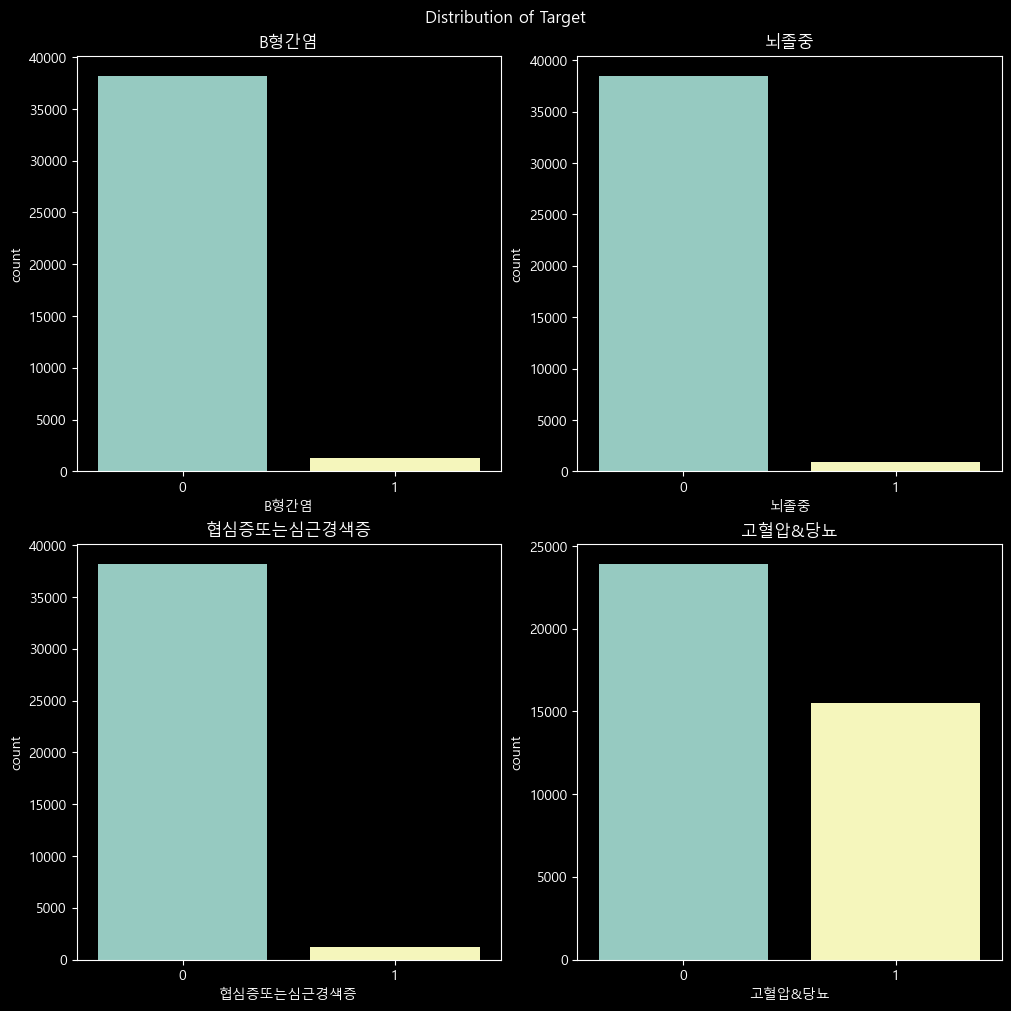

In [49]:
print(f"{target[0]} : 0 => {round(sum(fin_data[target[0]] == 0) / len(fin_data) * 100, 2)}%")
print(f"{target[0]} : 1 => {round(sum(fin_data[target[0]] == 1) / len(fin_data) * 100, 2)}%")
print()
print(f"{target[1]} : 0 => {round(sum(fin_data[target[1]] == 0) / len(fin_data) * 100, 2)}%")
print(f"{target[1]} : 1 => {round(sum(fin_data[target[1]] == 1) / len(fin_data) * 100, 2)}%")
print()
print(f"{target[2]} : 0 => {round(sum(fin_data[target[2]] == 0) / len(fin_data) * 100, 2)}%")
print(f"{target[2]} : 1 => {round(sum(fin_data[target[2]] == 1) / len(fin_data) * 100, 2)}%")
print()
print(f"{target[3]} : 0 => {round(sum(fin_data[target[3]] == 0) / len(fin_data) * 100, 2)}%")
print(f"{target[3]} : 1 => {round(sum(fin_data[target[3]] == 1) / len(fin_data) * 100, 2)}%")

fig, ax = plt.subplots(2,2, figsize = (10,10), constrained_layout=True)
ax = ax.flatten()

fig.suptitle('Distribution of Target')

for i in range(len(target)):
    sns.countplot(x = fin_data[target[i]], ax = ax[i])
    ax[i].set(title = target[i])

## Check NaN Data

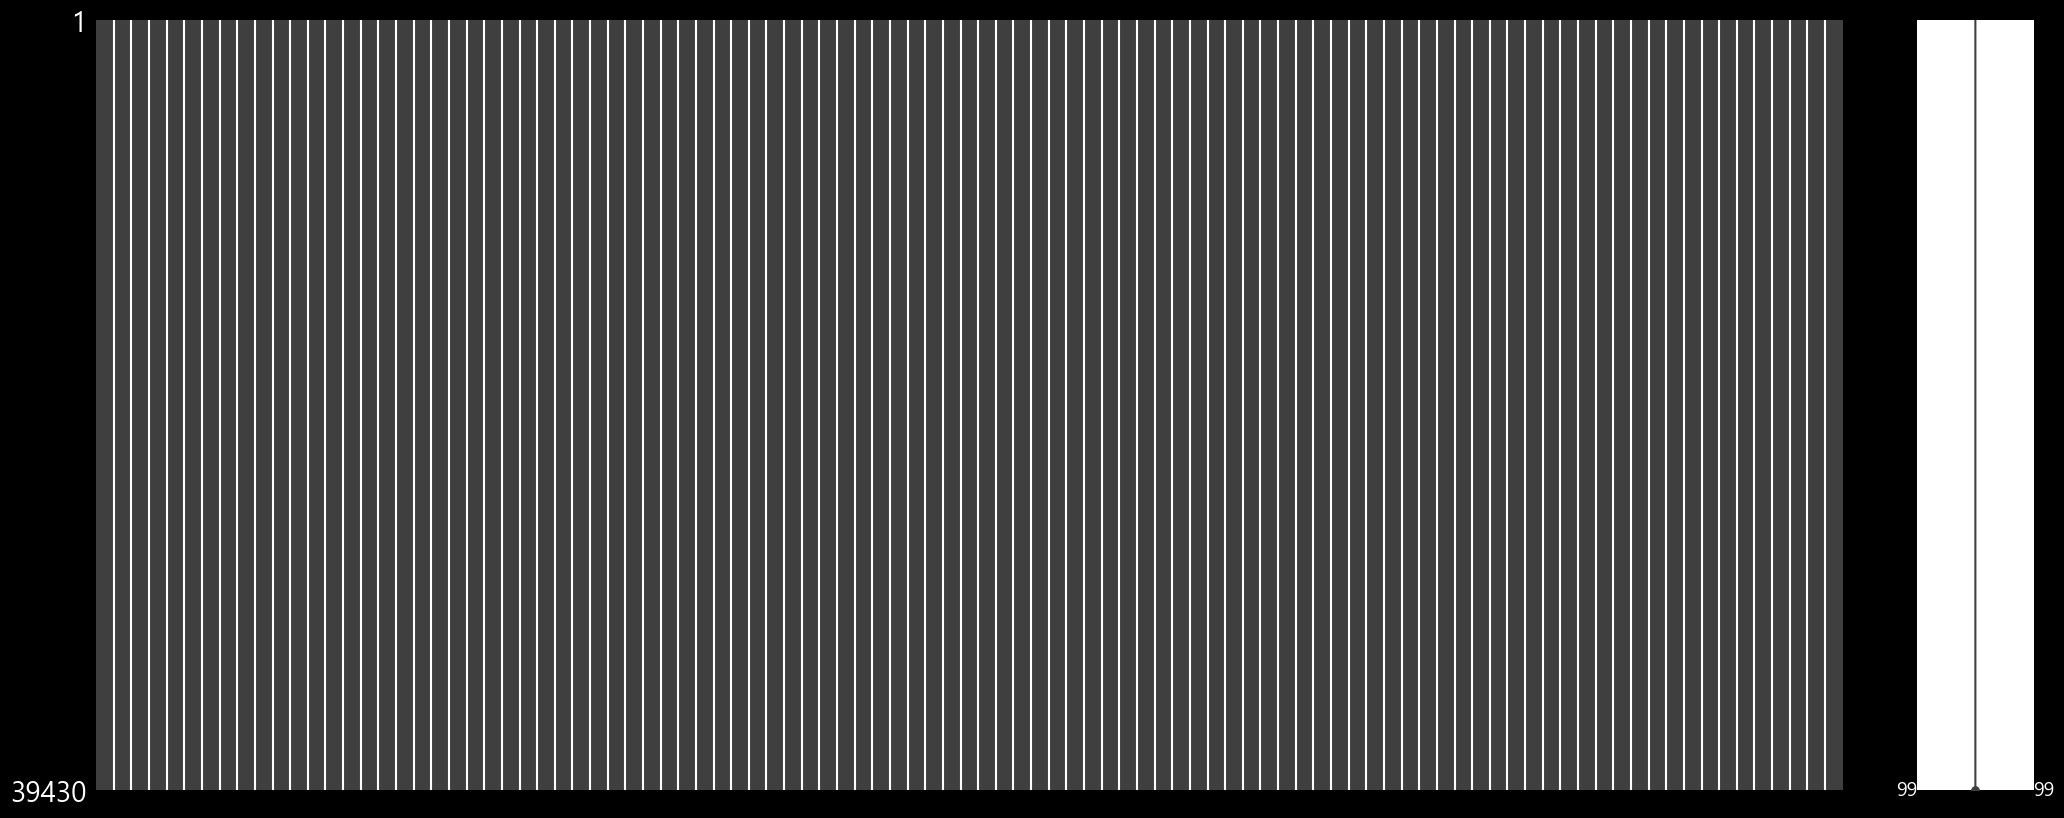

In [54]:
missingno.matrix(fin_data)
plt.show()

In [55]:
fin_data

,BP6_10,cfam,tins,BS3_1,region,occp,incm5,marri_2,EC_wht_5,EC_pedu_2,...,HE_DMfh2,HE_rPLS,HE_hepaB,HE_Unitr,B형간염,뇌졸중,협심증또는심근경색증,Target,bro_sis_existence,고혈압&당뇨
0,1.0,2.0,10.0,3.0,1.0,3.0,4.0,1.0,1.0,3.0,...,0.0,1.0,0.0,0.0,0,0,0,1,0,1
1,2.0,2.0,20.0,-1.0,1.0,7.0,2.0,1.0,-1.0,-2.0,...,0.0,1.0,0.0,0.0,0,0,0,1,1,1
2,2.0,2.0,10.0,-1.0,1.0,7.0,4.0,1.0,-1.0,3.0,...,1.0,1.0,0.0,0.0,0,0,0,1,0,1
3,2.0,2.0,10.0,1.0,1.0,5.0,2.0,8.0,1.0,5.0,...,1.0,1.0,0.0,0.0,0,0,0,1,0,1
4,2.0,1.0,10.0,-1.0,1.0,7.0,5.0,3.0,-1.0,1.0,...,1.0,1.0,0.0,0.0,0,0,0,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39425,2.0,4.0,20.0,-1.0,8.0,7.0,4.0,-1.0,-1.0,5.0,...,0.0,1.0,0.0,0.0,0,0,0,0,0,0
39426,2.0,2.0,20.0,-1.0,8.0,1.0,4.0,1.0,1.0,8.0,...,0.0,1.0,0.0,0.0,0,0,0,0,0,0
39427,2.0,2.0,20.0,-1.0,8.0,1.0,4.0,1.0,1.0,7.0,...,0.0,1.0,0.0,0.0,0,0,0,0,0,0
39428,2.0,3.0,20.0,-1.0,8.0,7.0,5.0,-1.0,-1.0,5.0,...,0.0,1.0,0.0,0.0,0,0,0,0,0,0


In [74]:
# categorical
cat_col = ['BE3_31', 'EC_pedu_2', 'mh_stress', 'town_t', 'HE_mens', 'marri_2', 'incm5', 'HE_STRfh1', 'HE_IHDfh1', 'fam_rela', 'genertn', 'EC1_1', 'cfam', 'EC_wht_5', 'HE_Ubil', 'HE_hepaB', 'HE_DMdr', 'tins', 'HE_IHDfh2', 'HE_Uket', 'HE_DMfh1', 'dr_month', 'HE_Ubld', 'BP6_10', 'HE_HPdr', 'HE_Unitr', 'educ', 'LW_br', 'allownc', 'HE_HLfh2', 'D_1_1', 'marri_1', 'BS3_1', 'region', 'HE_DMfh2', 'HE_Uro', 'BD1_11', 'bro_sis_existence', 'HE_STRfh2', 'BE5_1', 'HE_HPfh1', 'HE_HPfh2', 'HE_rPLS', 'sex', 'Target', 'EC_pedu_1', 'HE_HLfh1', 'edu', 'HE_Uglu', 'BP7', 'occp', 'HE_Upro', 'HE_prg']

# numerical
num_col = ['EC_wht_23', 'HE_fst', 'HE_sbp', 'HE_dbp', 'HE_ht', 'HE_wt', 'HE_wc', 'HE_BMI', 'HE_glu', 'HE_HbA1c', 'HE_chol', 'HE_HDL_st2', 'HE_TG', 'HE_ast', 'HE_alt', 'HE_HB', 'HE_HCT', 'HE_BUN', 'HE_crea', 'HE_WBC', 'HE_RBC', 'HE_Bplt', 'HE_Uph', 'HE_Usg', 'HE_Ucrea', 'N_INTK', 'N_EN', 'N_WATER', 'N_PROT', 'N_FAT', 'N_CHO', 'N_CA', 'N_PHOS', 'N_FE', 'N_NA', 'N_K', 'N_CAROT', 'N_RETIN', 'N_B1', 'N_B2', 'N_NIAC', 'N_VITC']



## One-hot encoding

In [75]:
categorical_data = fin_data[cat_col]
display(categorical_data)

,BE3_31,EC_pedu_2,mh_stress,town_t,HE_mens,marri_2,incm5,HE_STRfh1,HE_IHDfh1,fam_rela,...,sex,Target,EC_pedu_1,HE_HLfh1,edu,HE_Uglu,BP7,occp,HE_Upro,HE_prg
0,8.0,3.0,0.0,1.0,-1.0,1.0,4.0,0.0,0.0,1.0,...,1.0,1,3.0,0.0,3.0,0.0,2.0,3.0,0.0,-1.0
1,8.0,-2.0,0.0,1.0,0.0,1.0,2.0,0.0,0.0,2.0,...,2.0,1,-2.0,0.0,1.0,0.0,2.0,7.0,0.0,0.0
2,8.0,3.0,0.0,1.0,0.0,1.0,4.0,0.0,0.0,6.0,...,2.0,1,3.0,-2.0,3.0,0.0,2.0,7.0,0.0,0.0
3,2.0,5.0,1.0,1.0,-1.0,8.0,2.0,-2.0,-2.0,1.0,...,1.0,1,5.0,-2.0,3.0,0.0,2.0,5.0,0.0,-1.0
4,8.0,1.0,0.0,1.0,0.0,3.0,5.0,0.0,0.0,1.0,...,2.0,1,1.0,0.0,1.0,0.0,2.0,7.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39425,6.0,5.0,1.0,1.0,0.0,-1.0,4.0,0.0,0.0,3.0,...,2.0,0,7.0,0.0,3.0,0.0,2.0,7.0,0.0,0.0
39426,3.0,8.0,1.0,1.0,-1.0,1.0,4.0,0.0,0.0,2.0,...,1.0,0,7.0,0.0,4.0,0.0,2.0,1.0,0.0,-1.0
39427,5.0,7.0,0.0,1.0,0.0,1.0,4.0,0.0,0.0,1.0,...,2.0,0,7.0,0.0,4.0,0.0,2.0,1.0,0.0,0.0
39428,3.0,5.0,0.0,2.0,0.0,-1.0,5.0,0.0,0.0,3.0,...,2.0,0,5.0,1.0,3.0,0.0,2.0,7.0,0.0,0.0


In [79]:
# 원핫인코더 선언 및 Fitting
ohe = OneHotEncoder(sparse=False)
ohe.fit(categorical_data)

# 인코딩한 데이터로 변환
ohe_encoded = ohe.transform(categorical_data)

new_cat = pd.DataFrame(ohe_encoded)
display(new_cat)

,0,1,2,3,4,5,6,7,8,9,...,241,242,243,244,245,246,247,248,249,250
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,...,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39425,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
39426,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
39427,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
39428,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [80]:
# 기존의 카테고리형 컬럼 제거
display(fin_data)
fin_data_1 = fin_data.drop(cat_col, axis = 1)

# one-hot encoding column 추가
fin_data_c = pd.concat([fin_data_1, new_cat], axis = 1)
display(fin_data_c)

,BP6_10,cfam,tins,BS3_1,region,occp,incm5,marri_2,EC_wht_5,EC_pedu_2,...,HE_DMfh2,HE_rPLS,HE_hepaB,HE_Unitr,B형간염,뇌졸중,협심증또는심근경색증,Target,bro_sis_existence,고혈압&당뇨
0,1.0,2.0,10.0,3.0,1.0,3.0,4.0,1.0,1.0,3.0,...,0.0,1.0,0.0,0.0,0,0,0,1,0,1
1,2.0,2.0,20.0,-1.0,1.0,7.0,2.0,1.0,-1.0,-2.0,...,0.0,1.0,0.0,0.0,0,0,0,1,1,1
2,2.0,2.0,10.0,-1.0,1.0,7.0,4.0,1.0,-1.0,3.0,...,1.0,1.0,0.0,0.0,0,0,0,1,0,1
3,2.0,2.0,10.0,1.0,1.0,5.0,2.0,8.0,1.0,5.0,...,1.0,1.0,0.0,0.0,0,0,0,1,0,1
4,2.0,1.0,10.0,-1.0,1.0,7.0,5.0,3.0,-1.0,1.0,...,1.0,1.0,0.0,0.0,0,0,0,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39425,2.0,4.0,20.0,-1.0,8.0,7.0,4.0,-1.0,-1.0,5.0,...,0.0,1.0,0.0,0.0,0,0,0,0,0,0
39426,2.0,2.0,20.0,-1.0,8.0,1.0,4.0,1.0,1.0,8.0,...,0.0,1.0,0.0,0.0,0,0,0,0,0,0
39427,2.0,2.0,20.0,-1.0,8.0,1.0,4.0,1.0,1.0,7.0,...,0.0,1.0,0.0,0.0,0,0,0,0,0,0
39428,2.0,3.0,20.0,-1.0,8.0,7.0,5.0,-1.0,-1.0,5.0,...,0.0,1.0,0.0,0.0,0,0,0,0,0,0


,EC_wht_23,HE_fst,HE_sbp,HE_dbp,HE_ht,HE_wt,HE_wc,HE_BMI,HE_glu,HE_HbA1c,...,241,242,243,244,245,246,247,248,249,250
0,35.0,13.0,113.0,82.0,168.3,80.8,93.0,28.526148,126.0,6.7,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,-1.0,12.0,136.0,81.0,152.8,48.9,80.0,20.944122,72.0,7.2,...,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,-1.0,15.0,140.0,83.0,143.7,52.5,83.4,25.424110,120.0,7.6,...,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,48.0,14.0,116.0,73.0,172.8,81.7,87.2,27.361165,142.0,7.6,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,-1.0,12.0,110.0,68.0,159.2,60.2,87.2,23.752557,111.0,5.7,...,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39425,-1.0,12.0,110.0,75.0,165.3,46.9,62.7,17.164341,93.0,5.3,...,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
39426,40.0,12.0,99.0,52.5,177.6,61.5,68.7,19.497961,90.0,5.3,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
39427,33.0,13.0,108.0,66.0,155.3,52.2,65.6,21.643505,84.0,5.2,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
39428,-1.0,14.0,120.5,80.0,156.1,46.6,67.1,19.124061,76.0,4.7,...,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


## StandardScaler

In [81]:
display(fin_data[num_col])

,EC_wht_23,HE_fst,HE_sbp,HE_dbp,HE_ht,HE_wt,HE_wc,HE_BMI,HE_glu,HE_HbA1c,...,N_PHOS,N_FE,N_NA,N_K,N_CAROT,N_RETIN,N_B1,N_B2,N_NIAC,N_VITC
0,35.0,13.0,113.0,82.0,168.3,80.8,93.0,28.526148,126.0,6.7,...,1264.712881,17.112806,3883.919458,3024.696971,2084.410388,76.225234,1.795274,1.067851,29.155083,165.429678
1,-1.0,12.0,136.0,81.0,152.8,48.9,80.0,20.944122,72.0,7.2,...,636.963785,10.529593,2525.920352,1375.051681,678.630151,8.379165,0.698940,0.314588,19.929102,49.121530
2,-1.0,15.0,140.0,83.0,143.7,52.5,83.4,25.424110,120.0,7.6,...,380.652932,5.174307,1311.820525,1087.766549,839.146539,3.314914,0.446677,0.269494,6.259597,39.230529
3,48.0,14.0,116.0,73.0,172.8,81.7,87.2,27.361165,142.0,7.6,...,698.190081,6.280085,2788.557434,1854.710127,2353.098756,1.216971,0.493381,0.591819,11.205493,46.506535
4,-1.0,12.0,110.0,68.0,159.2,60.2,87.2,23.752557,111.0,5.7,...,1818.801026,15.331004,3177.713274,4943.790127,2218.114649,176.102642,2.136759,2.144746,20.180999,339.592884
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39425,-1.0,12.0,110.0,75.0,165.3,46.9,62.7,17.164341,93.0,5.3,...,1133.221932,5.334983,1979.773396,2293.998451,1465.540102,257.057647,0.751364,1.438779,18.303568,56.974859
39426,40.0,12.0,99.0,52.5,177.6,61.5,68.7,19.497961,90.0,5.3,...,1440.165638,27.519477,5643.156522,2960.915940,1506.947046,204.107345,0.976926,2.116615,16.141007,8.910790
39427,33.0,13.0,108.0,66.0,155.3,52.2,65.6,21.643505,84.0,5.2,...,1021.345273,15.790480,3375.449095,2685.157363,2086.165133,261.631357,0.574746,2.140382,10.393692,27.141891
39428,-1.0,14.0,120.5,80.0,156.1,46.6,67.1,19.124061,76.0,4.7,...,316.641527,2.502338,1325.771605,996.937146,726.549282,3.197158,0.500081,1.375065,3.694906,47.234103


In [84]:
# 연속형 변수만 가져오자
num_df = fin_data[num_col]

scaler = StandardScaler()
scaler.fit(num_df)

num_df_scaled = scaler.transform(num_df) 

num_scaled_df = pd.DataFrame(num_df_scaled, columns=num_df.columns) 
display(num_scaled_df)

,EC_wht_23,HE_fst,HE_sbp,HE_dbp,HE_ht,HE_wt,HE_wc,HE_BMI,HE_glu,HE_HbA1c,...,N_PHOS,N_FE,N_NA,N_K,N_CAROT,N_RETIN,N_B1,N_B2,N_NIAC,N_VITC
0,0.414321,-0.483201,-0.384062,0.677682,0.650108,1.448345,1.030663,1.321065,1.101903,1.078292,...,0.383768,0.183596,0.078318,0.082303,-0.274678,-0.135645,0.441397,-0.375350,1.653960,0.779847
1,-1.089742,-1.083303,0.971690,0.578149,-1.033750,-1.189522,-0.252185,-0.856705,-1.248488,1.677953,...,-0.827757,-0.139105,-0.431995,-0.996639,-0.569055,-0.331321,-0.806572,-1.222489,0.639578,-0.343973
2,-1.089742,0.717002,1.207473,0.777215,-2.022338,-0.891832,0.083329,0.430073,0.840748,2.157681,...,-1.322424,-0.401614,-0.888234,-1.184536,-0.535442,-0.345927,-1.093724,-1.273203,-0.863363,-0.439544
3,0.957455,0.116900,-0.207225,-0.218114,1.138970,1.522768,0.458316,0.986449,1.798315,2.157681,...,-0.709593,-0.347410,-0.333301,-0.682921,-0.218414,-0.351978,-1.040561,-0.910708,-0.319569,-0.369240
4,-1.089742,-1.083303,-0.560900,-0.715778,-0.338480,-0.255105,0.458316,-0.050044,0.449016,-0.121030,...,1.453132,0.096254,-0.187063,1.337475,-0.246680,0.152412,0.830113,0.835753,0.667274,2.462688
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39425,-1.089742,-1.083303,-0.560900,-0.019048,0.324200,-1.354906,-1.959358,-1.942363,-0.334447,-0.600759,...,0.129997,-0.393737,-0.637228,-0.395607,-0.404272,0.385895,-0.746897,0.041806,0.460853,-0.268091
39426,0.623219,-1.083303,-1.209303,-2.258538,1.660423,-0.147606,-1.367275,-1.272083,-0.465025,-0.600759,...,0.722384,0.693716,0.739409,0.040587,-0.395602,0.233181,-0.490136,0.804117,0.223083,-0.732507
39427,0.330762,-0.483201,-0.678791,-0.914844,-0.762160,-0.916639,-1.673185,-0.655823,-0.726179,-0.720691,...,-0.085919,0.118777,-0.112757,-0.139771,-0.274311,0.399087,-0.947943,0.830846,-0.408825,-0.556350
39428,-1.089742,0.116900,0.058031,0.478616,-0.675251,-1.379713,-1.525164,-1.379477,-1.074385,-1.320352,...,-1.445963,-0.532590,-0.882991,-1.243943,-0.559020,-0.346267,-1.032934,-0.029850,-1.145346,-0.362210


## Categorical + Numerical

In [88]:
fin_df = pd.concat([new_cat, num_scaled_df, fin_data[target]], axis = 1)
display(fin_df)

,0,1,2,3,4,5,6,7,8,9,...,N_CAROT,N_RETIN,N_B1,N_B2,N_NIAC,N_VITC,B형간염,뇌졸중,협심증또는심근경색증,고혈압&당뇨
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,-0.274678,-0.135645,0.441397,-0.375350,1.653960,0.779847,0,0,0,1
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,...,-0.569055,-0.331321,-0.806572,-1.222489,0.639578,-0.343973,0,0,0,1
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,-0.535442,-0.345927,-1.093724,-1.273203,-0.863363,-0.439544,0,0,0,1
3,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-0.218414,-0.351978,-1.040561,-0.910708,-0.319569,-0.369240,0,0,0,1
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,-0.246680,0.152412,0.830113,0.835753,0.667274,2.462688,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39425,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,-0.404272,0.385895,-0.746897,0.041806,0.460853,-0.268091,0,0,0,0
39426,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-0.395602,0.233181,-0.490136,0.804117,0.223083,-0.732507,0,0,0,0
39427,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,-0.274311,0.399087,-0.947943,0.830846,-0.408825,-0.556350,0,0,0,0
39428,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-0.559020,-0.346267,-1.032934,-0.029850,-1.145346,-0.362210,0,0,0,0


In [89]:
fin_df.to_csv('./data/train_data.csv')

# Model

## Data

In [91]:
data = pd.read_csv('./data/train_data.csv', index_col=0)
data

,0,1,2,3,4,5,6,7,8,9,...,N_CAROT,N_RETIN,N_B1,N_B2,N_NIAC,N_VITC,B형간염,뇌졸중,협심증또는심근경색증,고혈압&당뇨
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,-0.274678,-0.135645,0.441397,-0.375350,1.653960,0.779847,0,0,0,1
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,...,-0.569055,-0.331321,-0.806572,-1.222489,0.639578,-0.343973,0,0,0,1
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,-0.535442,-0.345927,-1.093724,-1.273203,-0.863363,-0.439544,0,0,0,1
3,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-0.218414,-0.351978,-1.040561,-0.910708,-0.319569,-0.369240,0,0,0,1
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,-0.246680,0.152412,0.830113,0.835753,0.667274,2.462688,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39425,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,-0.404272,0.385895,-0.746897,0.041806,0.460853,-0.268091,0,0,0,0
39426,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-0.395602,0.233181,-0.490136,0.804117,0.223083,-0.732507,0,0,0,0
39427,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,-0.274311,0.399087,-0.947943,0.830846,-0.408825,-0.556350,0,0,0,0
39428,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-0.559020,-0.346267,-1.032934,-0.029850,-1.145346,-0.362210,0,0,0,0


In [92]:
# 입력과 출력으로 분리하기
X = data.drop(target, axis=1).values
y = data[target].values

# 데이터 분할하기
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
# X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

## Metric

In [90]:
# 혼동행렬, 정확도, 정밀도, 재현율, F1, AUC 불러오기
def get_clf_eval(y_test, y_pred):
    accuracy = accuracy_score(y_test, y_pred)
    precision = metrics.precision_score(y_test, y_pred, average = None)
    recall = metrics.recall_score(y_test, y_pred, average = None)
    F1 = metrics.f1_score(y_test, y_pred, average = None)
    AUC = metrics.roc_auc_score(y_test, y_pred, average = None)
    print('\n정확도: {:.4f}'.format(accuracy))
    print('정밀도: {}'.format(precision))
    print('재현율: {}'.format(recall))
    print('F1: {}'.format(F1))
    print('AUC: {}'.format(AUC))
    return accuracy, F1

## Random Forest

In [98]:
start_time = time.time()
# 랜덤 포레스트 학습 및 별도의 테스트 세트로 예측 성능 평가
rf_clf = RandomForestClassifier(random_state=221)
rf_clf.fit(X_train, y_train)
end_time = time.time()
pred = rf_clf.predict(X_test)
print("Elapsed time:", end_time - start_time, "seconds")
random_time = end_time - start_time

Elapsed time: 16.404069900512695 seconds


In [99]:
acc_ran, f1_ran = get_clf_eval(y_test, pred)


정확도: 0.8999
정밀도: [1.         0.         0.         0.89739079]
재현율: [1.         0.         0.         0.97174603]
F1: [1.         0.         0.         0.93308947]
AUC: [1.       0.5      0.5      0.948922]


## XGBoost

In [102]:
# 넘파이 형태의 학습 데이터 세트와 테스트 데이터를 DMatrix로 변환하는 예제
dtrain = xgb.DMatrix(data=X_train, label = y_train)
dtest = xgb.DMatrix(data=X_test, label=y_test)

In [103]:
params = {'max_depth' : 3,
         'eta' : 0.1, 
         'objective' : 'binary:logistic',
         'eval_metric' : 'logloss',
         'early_stoppings' : 100 }

num_rounds = 400

start_time = time.time()
# train 데이터 세트는 'train', evaluation(test) 데이터 세트는 'eval' 로 명기
wlist = [(dtrain, 'train'), (dtest,'eval')]
# 하이퍼 파라미터와 early stopping 파라미터를 train() 함수의 파라미터로 전달
xgb_model = xgb.train(params = params, dtrain=dtrain, num_boost_round=num_rounds, evals=wlist)
end_time = time.time()


pred_probs = xgb_model.predict(dtest)
print('predict() 수행 결과값을 10개만 표시, 예측 확률 값으로 표시됨')
print(np.round(pred_probs[:10], 3))

# 예측 확률이 0.5보다 크면 1, 그렇지 않으면 0으로 예측값 결정해 리스트 객체인 preds에 저장
preds = np.where(pred_probs > 0.5, 1, 0)
print('예측값 10개만 표시: ', preds[:10])

[10:04:55] WARNING: C:/Users/administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "early_stoppings" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	train-logloss:0.60904	eval-logloss:0.60982
[1]	train-logloss:0.54025	eval-logloss:0.54175
[2]	train-logloss:0.48278	eval-logloss:0.48488
[3]	train-logloss:0.43425	eval-logloss:0.43686
[4]	train-logloss:0.39294	eval-logloss:0.39597
[5]	train-logloss:0.35734	eval-logloss:0.36081
[6]	train-logloss:0.32654	eval-logloss:0.33037
[7]	train-logloss:0.29972	eval-logloss:0.30388
[8]	train-logloss:0.27640	eval-logloss:0.28091
[9]	train-logloss:0.25582	eval-logloss:0.26063
[10]	train-logloss:0.23776	eval-logloss:0.24283
[11]	train-logloss:0.22160	eval-logloss:0.22693
[12]	train

[161]	train-logloss:0.06184	eval-logloss:0.07851
[162]	train-logloss:0.06175	eval-logloss:0.07849
[163]	train-logloss:0.06165	eval-logloss:0.07848
[164]	train-logloss:0.06157	eval-logloss:0.07846
[165]	train-logloss:0.06148	eval-logloss:0.07845
[166]	train-logloss:0.06136	eval-logloss:0.07845
[167]	train-logloss:0.06128	eval-logloss:0.07845
[168]	train-logloss:0.06121	eval-logloss:0.07841
[169]	train-logloss:0.06104	eval-logloss:0.07830
[170]	train-logloss:0.06098	eval-logloss:0.07829
[171]	train-logloss:0.06092	eval-logloss:0.07826
[172]	train-logloss:0.06081	eval-logloss:0.07821
[173]	train-logloss:0.06072	eval-logloss:0.07819
[174]	train-logloss:0.06065	eval-logloss:0.07817
[175]	train-logloss:0.06055	eval-logloss:0.07818
[176]	train-logloss:0.06046	eval-logloss:0.07819
[177]	train-logloss:0.06040	eval-logloss:0.07814
[178]	train-logloss:0.06033	eval-logloss:0.07815
[179]	train-logloss:0.06024	eval-logloss:0.07811
[180]	train-logloss:0.06011	eval-logloss:0.07809
[181]	train-logloss:

[329]	train-logloss:0.05004	eval-logloss:0.07729
[330]	train-logloss:0.04998	eval-logloss:0.07731
[331]	train-logloss:0.04990	eval-logloss:0.07734
[332]	train-logloss:0.04983	eval-logloss:0.07736
[333]	train-logloss:0.04978	eval-logloss:0.07733
[334]	train-logloss:0.04971	eval-logloss:0.07734
[335]	train-logloss:0.04967	eval-logloss:0.07733
[336]	train-logloss:0.04961	eval-logloss:0.07733
[337]	train-logloss:0.04956	eval-logloss:0.07733
[338]	train-logloss:0.04949	eval-logloss:0.07732
[339]	train-logloss:0.04942	eval-logloss:0.07735
[340]	train-logloss:0.04937	eval-logloss:0.07735
[341]	train-logloss:0.04932	eval-logloss:0.07736
[342]	train-logloss:0.04926	eval-logloss:0.07738
[343]	train-logloss:0.04922	eval-logloss:0.07740
[344]	train-logloss:0.04916	eval-logloss:0.07746
[345]	train-logloss:0.04909	eval-logloss:0.07746
[346]	train-logloss:0.04901	eval-logloss:0.07746
[347]	train-logloss:0.04894	eval-logloss:0.07744
[348]	train-logloss:0.04889	eval-logloss:0.07745
[349]	train-logloss:

In [106]:
print("Elapsed time:", end_time - start_time, "seconds")
xgb_time = end_time - start_time

Elapsed time: 101.80920100212097 seconds


In [104]:
acc_xgb, f1_xgb = get_clf_eval(y_test, preds)


정확도: 0.9096
정밀도: [1.         1.         0.17647059 0.94171393]
재현율: [1.         0.00478469 0.01102941 0.94888889]
F1: [1.         0.00952381 0.02076125 0.94528779]
AUC: [1.         0.50239234 0.50459535 0.95491319]


## lightGBM

In [107]:
# 혼동행렬, 정확도, 정밀도, 재현율, F1, AUC 불러오기
def get_clf_eval(y_test, y_pred):
    accuracy = accuracy_score(y_test, y_pred)
    precision = metrics.precision_score(y_test, y_pred, average = None)
    recall = metrics.recall_score(y_test, y_pred, average = None)
    F1 = metrics.f1_score(y_test, y_pred, average = None)
    # AUC = metrics.roc_auc_score(y_test, y_pred, average = None, multi_class='ovr')
    print('\n정확도: {:.4f}'.format(accuracy))
    print('정밀도: {}'.format(precision))
    print('재현율: {}'.format(recall))
    print('F1: {}'.format(F1))
    # print('AUC: {}'.format(AUC))
    return accuracy, F1

In [108]:
# y 변수 1차원 배열로 변환
y_train = y_train.argmax(axis=1)
y_test = y_test.argmax(axis=1)

In [109]:
# lgbm 모델 정의
params = {
    'objective': 'multiclass',
    'num_class': 4,
    'metric': 'multi_logloss'
}
model = lgb.LGBMClassifier(**params)

start_time = time.time()
# 모델 학습
model.fit(X_train, y_train)
end_time = time.time()

# 검증 데이터 예측
y_pred = model.predict(X_test)

In [110]:
print("Elapsed time:", end_time - start_time, "seconds")
lgbm_time = end_time - start_time

Elapsed time: 3.236344575881958 seconds


In [111]:
acc_gbm, f1_gbm = get_clf_eval(y_test, y_pred)


정확도: 0.9147
정밀도: [0.96994536 0.1        0.27586207 0.83813532]
재현율: [0.97816872 0.00487805 0.03361345 0.95009174]
F1: [0.97403968 0.00930233 0.05992509 0.89060888]


# Visualize

## Accuracy

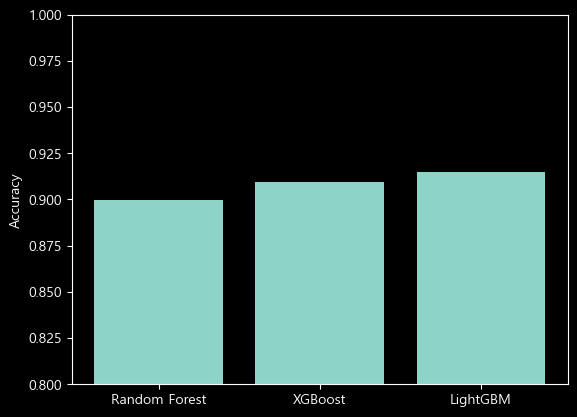

In [116]:
# 그래프 그리기
labels = ['Random Forest', 'XGBoost', 'LightGBM']
accs = [acc_ran, acc_xgb, acc_gbm]

plt.bar(labels, accs)
plt.ylim(0.8, 1)
plt.ylabel('Accuracy')
plt.show()

## Time

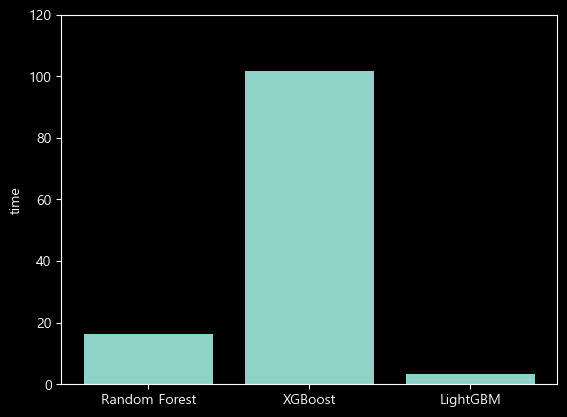

In [151]:
# 그래프 그리기
labels = ['Random Forest', 'XGBoost', 'LightGBM']
accs = [random_time, xgb_time, lgbm_time]

plt.bar(labels, accs)
plt.ylim(0, 120)
plt.ylabel('time')
plt.show()

## F1-score

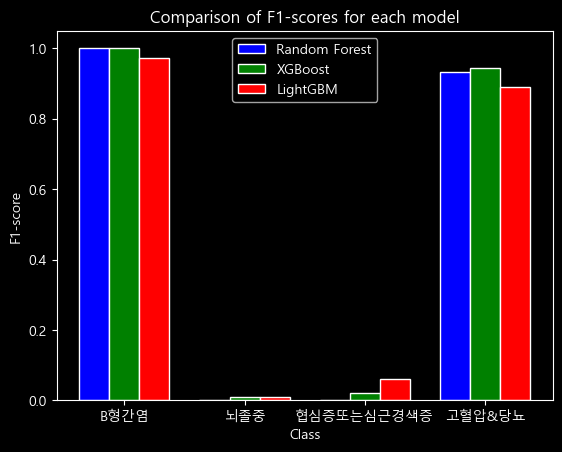

In [118]:
# F1-scores for each model
rf_scores = f1_ran
xgb_scores = f1_xgb
lgbm_scores = f1_gbm

# Set the width of each bar
barWidth = 0.25

# Set the x-axis labels
labels = ['B형간염', '뇌졸중', '협심증또는심근경색증', '고혈압&당뇨']

# Set the x-axis positions for each group of bars
r1 = np.arange(len(rf_scores))
r2 = [x + barWidth for x in r1]
r3 = [x + barWidth for x in r2]

# Create the bar chart
plt.bar(r1, rf_scores, color='blue', width=barWidth, edgecolor='white', label='Random Forest')
plt.bar(r2, xgb_scores, color='green', width=barWidth, edgecolor='white', label='XGBoost')
plt.bar(r3, lgbm_scores, color='red', width=barWidth, edgecolor='white', label='LightGBM')

# Add x-axis labels and title
plt.xticks([r + barWidth for r in range(len(rf_scores))], labels)
plt.xlabel('Class')
plt.ylabel('F1-score')
plt.title('Comparison of F1-scores for each model')

# Add legend
plt.legend()

# Show the chart
plt.show()

- 상대적으로 불균형이 심한 "뇌졸중", "협심증또는심근경색증" column 에 대해서 LightGBM 모델이 좋은 성능을 보인다.
    - LightGBM으로 모델 고정 후 Data Imbalance 문제를 해결 시도

# Resolving Data Imbalance Problem

- 우선 LightGBM의 균형 트리 분할 알고리즘 덕에 데이터 불균형 문제가 완화되었으므로 이를 가져가자.

- 다음으로 데이터 불균형 문제를 해결하기 위해 사용할 기법들은 다음과 같다.
    - 클래스 가중치 조정 : 소수 클래스에 대한 오분류 비용을 더 높게 부여
    - 샘플링 전략 : 적은 클래스에 대해 샘플링 -> 언더샘플링, 오버샘플링, SMOTE
    - Early Stopping : 학습을 조기에 중단하여 소수 클래스의 overfitting 방지

In [119]:
data = pd.read_csv('./data/train_data.csv', index_col=0)

In [120]:
# 입력과 출력으로 분리하기
X = data.drop(target, axis=1).values
y = data[target].values

# 데이터 분할하기
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# y 변수 1차원 배열로 변환
y_train = y_train.argmax(axis=1)
y_test = y_test.argmax(axis=1)

## Class weight

In [121]:
# 클래스 가중치를 설정합니다.
class_weight = {0: 1, 1: 10, 2: 10, 3: 1}

# lgbm 모델 정의
params = {
    'objective': 'multiclass',
    'num_class': 4,
    'metric': 'multi_logloss'
}
model = lgb.LGBMClassifier(**params, class_weight=class_weight)

# 모델 학습
model.fit(X_train, y_train)

# 검증 데이터 예측
y_pred = model.predict(X_test)

In [122]:
acc_gbm_w, f1_gbm_w = get_clf_eval(y_test, y_pred)


정확도: 0.8934
정밀도: [0.97026571 0.16071429 0.21212121 0.86398537]
재현율: [0.97520136 0.08780488 0.26470588 0.86715596]
F1: [0.97272727 0.11356467 0.23551402 0.86556777]


## Sampling

In [123]:
# SMOTE를 사용하여 데이터셋을 오버샘플링
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

In [124]:
# lgbm 모델 정의
params = {
    'objective': 'multiclass',
    'num_class': 4,
    'metric': 'multi_logloss'
}
model = lgb.LGBMClassifier(**params)

# 모델 학습
model.fit(X_train_resampled, y_train_resampled)

# 검증 데이터 예측
y_pred = model.predict(X_test)

In [125]:
acc_gbm_s, f1_gbm_s = get_clf_eval(y_test, y_pred)


정확도: 0.9105
정밀도: [0.97220454 0.25       0.25352113 0.83398058]
재현율: [0.97117423 0.01463415 0.07563025 0.94568807]
F1: [0.97168911 0.02764977 0.11650485 0.88632846]


## Early Stopping

In [128]:
# 입력과 출력으로 분리하기
X = data.drop(target, axis=1).values
y = data[target].values

# 데이터 분할하기
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

# y 변수 1차원 배열로 변환
y_train = y_train.argmax(axis=1)
y_valid = y_valid.argmax(axis=1)
y_test = y_test.argmax(axis=1)

# LightGBM 데이터셋으로 변환
train_data = lgb.Dataset(X_train, label=y_train)
valid_data = lgb.Dataset(X_valid, label=y_valid)

In [129]:
# LightGBM 모델 학습을 위한 하이퍼파라미터를 설정합니다.
params = {
    'objective': 'multiclass',
    'num_class': 4,  # 클래스 개수
    'metric': 'multi_logloss',
    'num_leaves': 31,
    'learning_rate': 0.05,
    'feature_fraction': 0.9,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'verbose': -1
}

# LightGBM 모델을 학습합니다.
num_rounds = 1000
model = lgb.train(params, train_data, num_rounds, valid_sets=[train_data, valid_data], verbose_eval=100, early_stopping_rounds=50)

# 예측을 수행합니다.
y_pred = model.predict(X_test)
y_pred_max = np.argmax(y_pred, axis=1)

Training until validation scores don't improve for 50 rounds
[100]	training's multi_logloss: 0.111103	valid_1's multi_logloss: 0.227891
Early stopping, best iteration is:
[145]	training's multi_logloss: 0.0806585	valid_1's multi_logloss: 0.224646


In [130]:
acc_gbm_e, f1_gbm_e = get_clf_eval(y_test, y_pred_max)


정확도: 0.9158
정밀도: [0.96952501 0.         0.42105263 0.83687259]
재현율: [0.97774481 0.         0.03361345 0.95449541]
F1: [0.97361756 0.         0.06225681 0.89182239]


- Class weight 와 Sampling 기법을 사용했을 때 성능이 올라갔다.
- Early Stopping 기법을 사용했을 때는 효과가 없었다. 오히려 떨어지는 경향을 보였다.

---
**Class weight 와 Sampling 둘을 같이 사용하자.**

## Class weight & Early Stopping

- 기법을 사용했을 때와 사용하지 않았을 때를 비교

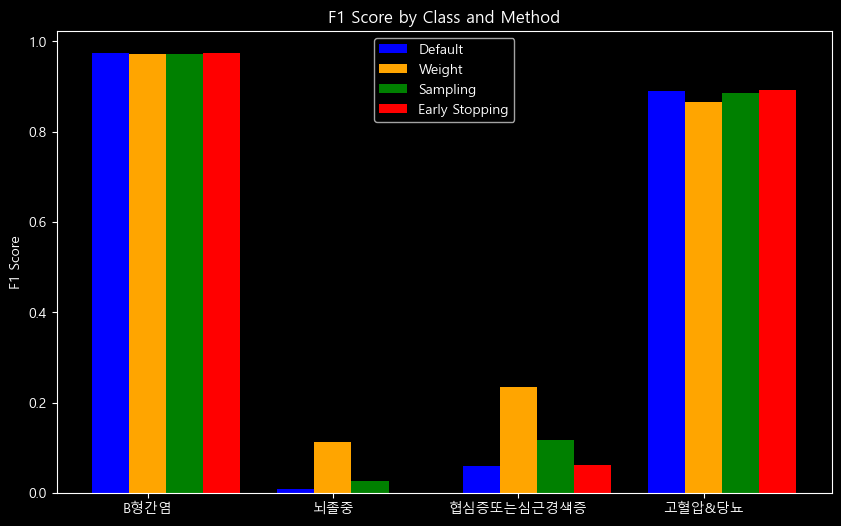

In [133]:
labels = ['B형간염', '뇌졸중', '협심증또는심근경색증', '고혈압&당뇨']

x = np.arange(len(labels))
width = 0.2

fig, ax = plt.subplots(figsize=(10,6))
rects1 = ax.bar(x - width, f1_gbm, width, label='Default', color='blue')
rects2 = ax.bar(x, f1_gbm_w, width, label='Weight', color='orange')
rects3 = ax.bar(x + width, f1_gbm_s, width, label='Sampling', color='green')
rects4 = ax.bar(x + width*2, f1_gbm_e, width, label='Early Stopping', color='red')

ax.set_ylabel('F1 Score')
ax.set_title('F1 Score by Class and Method')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

plt.show()

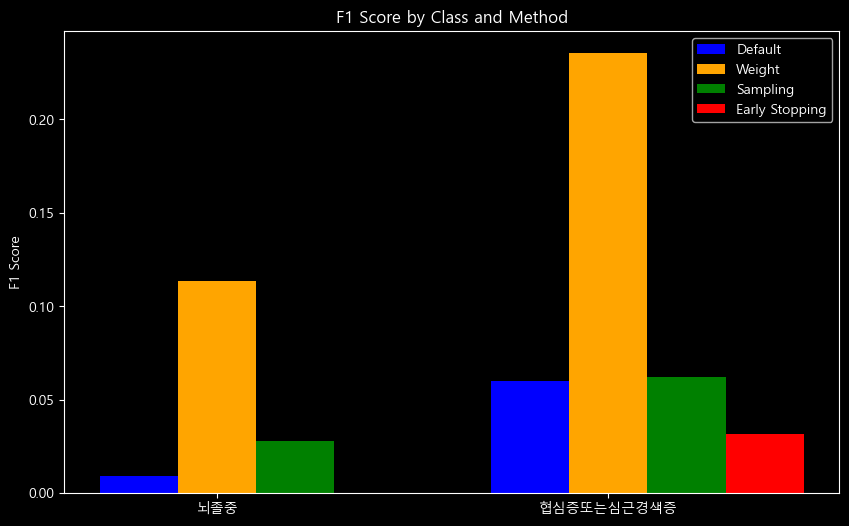

In [136]:
f1_gbm = [0.00930233, 0.05992509]
f1_gbm_w = [0.11356467 , 0.23551402]
f1_gbm_s = [0.02764977 , 0.06225681]
f1_gbm_e = [0., 0.03174603]
labels = ['뇌졸중', '협심증또는심근경색증']

x = np.arange(len(labels))
width = 0.2

fig, ax = plt.subplots(figsize=(10,6))
rects1 = ax.bar(x - width, f1_gbm, width, label='Default', color='blue')
rects2 = ax.bar(x, f1_gbm_w, width, label='Weight', color='orange')
rects3 = ax.bar(x + width, f1_gbm_s, width, label='Sampling', color='green')
rects4 = ax.bar(x + width*2, f1_gbm_e, width, label='Early Stopping', color='red')

ax.set_ylabel('F1 Score')
ax.set_title('F1 Score by Class and Method')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

plt.show()

In [137]:
# 입력과 출력으로 분리하기
X = data.drop(target, axis=1).values
y = data[target].values

# 데이터 분할하기
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# y 변수 1차원 배열로 변환
y_train = y_train.argmax(axis=1)
y_test = y_test.argmax(axis=1)

In [138]:
# SMOTE를 사용하여 데이터셋을 오버샘플링
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

In [139]:
# 클래스 가중치를 설정합니다.
class_weight = {0: 1, 1: 10, 2: 10, 3: 1}

# lgbm 모델 정의
params = {
    'objective': 'multiclass',
    'num_class': 4,
    'metric': 'multi_logloss'
}
model = lgb.LGBMClassifier(**params, class_weight=class_weight)

# 모델 학습
model.fit(X_train_resampled, y_train_resampled)

# 검증 데이터 예측
y_pred = model.predict(X_test)

In [140]:
acc_gbm_we, f1_gbm_we = get_clf_eval(y_test, y_pred)


정확도: 0.8528
정밀도: [0.97657929 0.12275449 0.16104869 0.86844332]
재현율: [0.96333192 0.2        0.36134454 0.7533945 ]
F1: [0.96991037 0.15213358 0.22279793 0.80683828]


In [143]:
f1_gbm_ws = [0.15213358, 0.22279793]

In [144]:
print(f1_gbm_w)
print(f1_gbm_s)
print(f1_gbm_e)
print(f1_gbm_ws)

[0.11356467, 0.23551402]
[0.02764977, 0.06225681]
[0.0, 0.03174603]
[0.15213358, 0.22279793]


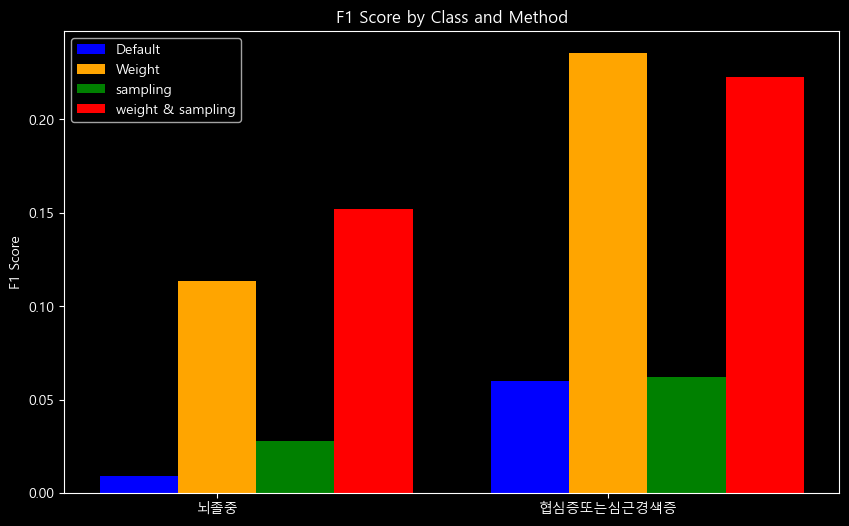

In [152]:
labels = ['뇌졸중', '협심증또는심근경색증']

x = np.arange(len(labels))
width = 0.2

fig, ax = plt.subplots(figsize=(10,6))
rects1 = ax.bar(x - width, f1_gbm, width, label='Default', color='blue')
rects2 = ax.bar(x, f1_gbm_w, width, label='Weight', color='orange')
rects3 = ax.bar(x + width, f1_gbm_s, width, label='sampling', color='green')
rects4 = ax.bar(x + width*2, f1_gbm_ws, width, label='weight & sampling', color='red')

ax.set_ylabel('F1 Score')
ax.set_title('F1 Score by Class and Method')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

plt.show()

# Check your Insurance Premium

## Model training

In [153]:
# 입력과 출력으로 분리하기
X = data.drop(target, axis=1).values
y = data[target].values

# 데이터 분할하기
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# y 변수 1차원 배열로 변환
y_train = y_train.argmax(axis=1)
y_test = y_test.argmax(axis=1)

In [154]:
# SMOTE를 사용하여 데이터셋을 오버샘플링
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

In [155]:
# 클래스 가중치를 설정합니다.
class_weight = {0: 1, 1: 10, 2: 10, 3: 1}

# lgbm 모델 정의
params = {
    'objective': 'multiclass',
    'num_class': 4,
    'metric': 'multi_logloss'
}
model = lgb.LGBMClassifier(**params, class_weight=class_weight)

# 모델 학습
model.fit(X_train_resampled, y_train_resampled)


LGBMClassifier(class_weight={0: 1, 1: 10, 2: 10, 3: 1}, metric='multi_logloss',
               num_class=4, objective='multiclass')

In [167]:
X_train.shape

(31544, 293)

## Apply
- 밑에 input은 하나의 예시이다.
- 각 사용자에 대한 결과는 웹사이트에서 확인해주세요 (발표 자료에 QR코드를 첨부하였습니다.)
    - 해당 링크 : https://seongmincc-streamlit-data-app-flf9zu.streamlit.app/
---
**웹사이트 사용 방법**
1. 당신의 건강 상태를 해당 설명에 맞게 입력해주세요.
2. predict 버튼을 누르면 당신의 각 질병에 대한 확률값이 나오게됩니다.
3. 확인이 끝났다면 왼쪽 목차에 Insurance 페이지를 들어가주세요.
4. 해당 칸에 당신의 나이와 지불할 수 있는 보험료를 적어주세요.
5. submit 버튼을 눌러 당신에게 추천되는 보험 특약 내용을 확인해주세요


---

**웹사이트에 다음 예시를 적용해보세요!**

| 공복혈당 | 최종 이완기 혈압(2,3차 평균) | 최종 수축기 혈압(2,3차 평균) | 당화혈색소 | 허리둘레 | 체질량지수 | 신장 | 주당 평균 근로시간 | 체중 | 공복시간 |
| :--------: | :--------: | :--------: | :--------: | :--------: | :--------: | :--------: | :--------: | :--------: | :--------: | 
| 120.0 | 83.0 | 140.0 | 7.6 | 83.4 | 25.4 | 143.7 | -1.0 | 52.5 | 15.0 | 
| 142.0 | 73.0 | 116.0 | 7.6 | 87.2 | 27.3 | 172.8 | 48.0 | 81.7 | 14.0 | 
| 76.0 | 80.0 | 120.5 | 4.7 | 67.1| 19.1 | 156.1 | -1.0 | 46.6 | 14.0 | 

*Thank you*

**코드에서의 확인을 위해 watson이라는 변수를 만들었습니다.**


In [170]:
data = pd.read_csv('./data/train_data.csv', index_col=0)
watson = data.iloc[6][:-4].values.reshape(1, -1)

In [178]:
# data 불러오기
insurance_premium=pd.read_excel('./data/insurance_premium.xlsx')

def print_code(price_min, price_gap, disease_risk_li, insurance_premium_max):
    # 기본 특약 계산을 위한 변수
    disease_risk_avg = sum(disease_risk_li)/4
    
    # 특약별 보험료 계산을 위한 리스트
    value_min=[0,0,0,0,0]; value_rate=[0,0,0,0,0]; sum_value_rate=[0,0,0,0,0]
    
    # 보험료 계산에 필요한 값들 정리
    for i in range(5):
        value_min[i]=sum(price_min*np.array(insurance_premium.iloc[:,i+6]))
    sum_value_min=sum(value_min)
    
    value_rate[0]=price_gap*np.array(insurance_premium['기본특약'])*disease_risk_avg
    for i in range(1,5):
        value_rate[i]=price_gap*np.array(insurance_premium.iloc[:,i+6])*disease_risk_li[i-1]
    sum_value_rate_disease=np.sum(np.array(value_rate[1:5]))
    
    # 보험료 출력을 위한 이름 리스트
    name_list=['일반특약','심혈관질환 ','대사질환 ','뇌혈관질환 ','간질환 ']
    
    # 보험료 총합을 계산하기 위한 변수
    price_total=0
    
    # 보험료 출력을 위한 보험료 재조정과 출력
    if sum_value_min>insurance_premium_max:
        print('설정한 최소 보험료가 너무 낮습니다. 계산된 최소 보험료 : %d'%sum_value_min)

    elif sum_value_min+sum_value_rate_disease>insurance_premium_max:
        print('예산이 부족하여 질병을 대비하기 위한 특약의 보험료를 먼저 채웁니다.')
        print('---------------')

        # 보험료 예산에 맞춘 보험료 재조정
        for i in range(1,5):
            sum_value_rate[i]=np.floor(sum(value_rate[i]*((insurance_premium_max-sum_value_min)/sum_value_rate_disease)))

        # 보험료 출력하기
        print('기 본 : %d원 / %d원'%(value_min[0], value_min[0]+int(sum(value_rate[0]))))
        price_total+=value_min[0]
        for i in range(1,5):
            print('{0} : {1}원 / {2}원'.format(name_list[i], int(value_min[i]+sum_value_rate[i]), value_min[i]+int(sum(value_rate[i]))))
            price_total+=int(value_min[i]+sum_value_rate[i])
            
        print('---------------')
        print('전체 보험료 : %d원'%price_total)
        print('남은 예  산 : %d원'%(insurance_premium_max-price_total))

    else:
        print('예산이 충분하여 기본특약의 보험료를 더 높입니다.')
        print('---------------')

        # 보험료 예산에 맞춘 보험료 재조정
        tmp=sum_value_min+sum_value_rate_disease
        tmp_value1_rate=value_rate[0]*(insurance_premium_max-tmp)/sum(value_rate[0])

        # 보험료 출력하기
        if value_min[0]+sum(tmp_value1_rate)>=value_min[0]+sum(value_rate[0]):
            print('기 본 : %d원 / %d원'%(value_min[0]+sum(value_rate[0]), value_min[0]+sum(value_rate[0])))
            price_total+=value_min[0]+sum(value_rate[0])
        else:
            print('기 본 : %d원 / %d원'%(value_min[0]+sum(tmp_value1_rate), value_min[0]+sum(value_rate[0])))
            price_total+=value_min[0]+sum(tmp_value1_rate)
        for i in range(1,5):
            print('{0} : {1}원 / {1}원'.format(name_list[i], value_min[i]+int(sum(value_rate[i]))))
            price_total+=value_min[i]+int(sum(value_rate[i]))
            
        print('---------------')
        print('전체 보험료 : %d원'%price_total)
        print('남은 예  산 : %d원'%(insurance_premium_max-price_total))


# 보험료 계산기
# insurance_premium : data
# disease_risk_li : 입력된 질병별 위험도
# age : 나이
# insurance_premium_max : 이용자가 원하는 보험료
def calculator(insurance_premium, disease_risk_li, age, insurance_premium_max):
    
    # 나이대에 따른 최대 보험료, 최소 보험료 뽑아오기
    if 19<age<30:
        price_min = np.array(insurance_premium.iloc[:,2])
        price_max = np.array(insurance_premium.iloc[:,3])
        price_gap = np.floor(np.array(price_max-price_min))
        
        print_code(price_min, price_gap, disease_risk_li, insurance_premium_max)
        
    elif 39<age<50:
        price_min = np.array(insurance_premium.iloc[:,4])
        price_max = np.array(insurance_premium.iloc[:,5])
        price_gap = np.floor(np.array(price_max-price_min))
        
        print_code(price_min, price_gap, disease_risk_li, insurance_premium_max)
        
    else:
        print('죄송합니다. 현재 고객님을 위한 상품이 준비되어 있지 않습니다.')
        print('현재 저희는 20대와 40대를 위한 상품만 제공되고 있습니다.')

In [179]:
prediction_proba = model.predict_proba(watson)
prediction_proba = prediction_proba.tolist()[0]
prediction_proba

[0.027596433825690634,
 0.12819727383135512,
 0.2418737631206445,
 0.6023325292223097]

In [181]:
calculator(insurance_premium, prediction_proba, 24, 50000) # 파일, 확률, 

예산이 부족하여 질병을 대비하기 위한 특약의 보험료를 먼저 채웁니다.
---------------
기 본 : 37802원 / 177045원
심혈관질환  : 5550원 / 7480원
대사질환  : 322원 / 410원
뇌혈관질환  : 3793원 / 15992원
간질환  : 2532원 / 7859원
---------------
전체 보험료 : 49999원
남은 예  산 : 1원
